In [7]:
import numpy as np
import pandas as pd
import patsy
import itertools

from sklearn.linear_model import (Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, 
                     LassoCV, ElasticNetCV,  SGDRegressor, SGDClassifier)

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn import grid_search, datasets

import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<center>
<h1> <b> Problem statement </b> <h1>
<h2> <center>  What relationship are there between PGE electrical usage  and solar power accumulation 
in CA in 2012 - 2016?  </h2>
</center>

Context: In CA, California Public Utilities Commision (CPUC) regulates California’s three large investor owned electric utilities – Pacific Gas and Electric (PG&E), Southern California Edison (SCE), and San Diego Gas and Electric (SDG&E). This study focuses on just PGE, so it is therefore incomplete.
<br>
As we see some of the numbers below, PG&E only covers a portions of the state's area.
<br>
This means that only 818/2667 = 0.3067 ZIP codes have solar power in CA! The PGE number depends on the sampling rate. Since ZIP codes are propotional to population, PG&E covers only about 30% of CA.
<br>
I have not found yet another study of PG&E electical usage vs solar power generation, so I cannot compare these results with any prior work.


<center>
<h2> 1. Load in Q1 - Q2 for 2012 -  2016 electric data from PG&E  </h2>
</center>

In [8]:
#2016, Q1-Q2
pge_q1 = pd.read_csv("PGE_2016_Q1_ElectricUsageByZip.csv")
pge_q2 = pd.read_csv("PGE_2016_Q2_ElectricUsageByZip.csv")

#2015, Q1-Q2
pge_q3 = pd.read_csv("PGE_2015_Q1_ElectricUsageByZip.csv")
pge_q4 = pd.read_csv("PGE_2015_Q2_ElectricUsageByZip.csv")

# 2014
pge_q5 = pd.read_csv("PGE_2014_Q1_ElectricUsageByZip.csv")
pge_q6 = pd.read_csv("PGE_2014_Q2_ElectricUsageByZip.csv")

#2013
pge_q7 = pd.read_csv("PGE_2013_Q1_ElectricUsageByZip.csv")
pge_q8 = pd.read_csv("PGE_2013_Q2_ElectricUsageByZip.csv")

#2012
pge_q9 = pd.read_csv("PGE_2012_Q1_ElectricUsageByZip.csv")
pge_q10 = pd.read_csv("PGE_2012_Q2_ElectricUsageByZip.csv")

In [9]:
pge_q1.head()

ZipCode  Month  Year      CustomerClass Combined TotalCustomers TotalkWh  \
0    93101      1  2016   Elec- Commercial        Y              0        0   
1    93101      1  2016  Elec- Residential        Y              0        0   
2    93105      1  2016   Elec- Commercial        Y              0        0   
3    93105      1  2016  Elec- Residential        Y              0        0   
4    93110      1  2016   Elec- Commercial        Y              0        0   

  AveragekWh  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [10]:
pge_q2.tail()

ZipCode  Month  Year      CustomerClass Combined TotalCustomers  \
7733    96130      6  2016   Elec- Commercial        Y              0   
7734    96137      6  2016   Elec- Commercial        Y              0   
7735    96137      6  2016  Elec- Residential        N          2,666   
7736    96161      6  2016   Elec- Commercial        Y              0   
7737    96161      6  2016  Elec- Residential        Y              0   

     TotalkWh AveragekWh  
7733        0        NaN  
7734        0        NaN  
7735  942,959        354  
7736        0        NaN  
7737        0        NaN

<h2> 2. Let's do some data cleanup & EDA </h2>

In [11]:
pge_q1_df = pd.DataFrame(pge_q1)
pge_q2_df = pd.DataFrame(pge_q2)
pge_q3_df = pd.DataFrame(pge_q3)
pge_q4_df = pd.DataFrame(pge_q4)
pge_q5_df = pd.DataFrame(pge_q5)
pge_q6_df = pd.DataFrame(pge_q6)
pge_q7_df = pd.DataFrame(pge_q7)
pge_q8_df = pd.DataFrame(pge_q8)
pge_q9_df = pd.DataFrame(pge_q9)
pge_q10_df = pd.DataFrame(pge_q10)

In [12]:
pge_q = pd.concat([pge_q1_df, pge_q2_df, pge_q3_df, pge_q4_df, pge_q5_df, pge_q6_df, 
                  pge_q8_df, pge_q9_df, pge_q10_df])

In [13]:
pge_q.shape

(68587, 8)

<h3> For analysis on the Mac Book Pro I wil use only a fraction of the full data. I will use the full data set
when I run this on an AWS host.  </h3>

In [14]:
pge_q = pge_q.sample(frac=0.05)

In [15]:
pge_q.shape

(3429, 8)

In [16]:
pge_q.columns = [x.replace(',','') for x in pge_q.columns]

In [17]:
pge_q['AveragekWh']  = [ np.nan_to_num(x) for x in  pge_q['AveragekWh']]

In [18]:
pge_q.TotalkWh = [(x.replace(',','')) for x in pge_q.TotalkWh]

In [19]:
pge_q.Combined = pge_q.Combined.map(lambda x: 1 if x == 'N' else 0)

In [20]:
pge_q.CustomerClass.unique()

array(['Elec- Commercial', 'Elec- Residential', 'Elec- Industrial',
       'Elec- Agricultural'], dtype=object)

I will map the CustomerClass into interger vars.

In [21]:
def cust_clean(x):
    
    if x == 'Elec- Commercial':
        x  = 1
    elif x == 'Elec- Residential':
         x = 2
    elif x == 'Elec- Agricultural':
         x = 3
    elif x == 'Elec- Industrial':
         x = 4

    return x

In [22]:
pge_q.CustomerClass = pge_q.CustomerClass.apply(cust_clean)

In [23]:
pge_q.CustomerClass.unique()

array([1, 2, 4, 3])

In [24]:
pge_q.AveragekWh.head()

1251      0
933     583
2588    580
2381    748
4040    674
Name: AveragekWh, dtype: object

In [25]:
pge_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3429 entries, 1251 to 7479
Data columns (total 8 columns):
ZipCode           3429 non-null int64
Month             3429 non-null int64
Year              3429 non-null int64
CustomerClass     3429 non-null int64
Combined          3429 non-null int64
TotalCustomers    3429 non-null object
TotalkWh          3429 non-null object
AveragekWh        3429 non-null object
dtypes: int64(5), object(3)
memory usage: 241.1+ KB


In [26]:
len(pge_q['ZipCode'].unique())

858

In [27]:
len(pge_q['TotalCustomers'].unique())

1307

In [28]:
pge_q_num_cols = pge_q.columns
print pge_q_num_cols
pge_q_num = pge_q[pge_q_num_cols]

Index([u'ZipCode', u'Month', u'Year', u'CustomerClass', u'Combined',
       u'TotalCustomers', u'TotalkWh', u'AveragekWh'],
      dtype='object')


In [29]:
pge_q_num.TotalCustomers = [x.replace(',','') for x in pge_q_num.TotalCustomers]

In [30]:
pge_q_num['AveragekWh_22'] = pge_q_num['AveragekWh'].astype(str)

In [31]:
pge_q_num.AveragekWh_22 = [x.replace(',','') for x in pge_q_num.AveragekWh_22]

In [32]:
pge_q_num = pge_q_num[pge_q_num.Combined != 0]

In [33]:
pge_q_num.TotalCustomers = pge_q_num.TotalCustomers.astype(float)
pge_q_num.TotalkWh = pge_q_num.TotalkWh.astype(float)
pge_q_num.AveragekWh_22 = pge_q_num.AveragekWh_22.astype(float)
pge_q_num.AveragekWh = pge_q_num.AveragekWh_22

In [34]:
del pge_q_num['AveragekWh_22']

In [35]:
pge_q_num.head(3)

ZipCode  Month  Year  CustomerClass  Combined  TotalCustomers  \
933     94561      4  2013              2         1         12037.0   
2588    93249      5  2013              2         1           513.0   
2381    95972      4  2013              2         1            83.0   

       TotalkWh  AveragekWh  
933   7017793.0       583.0  
2588   297597.0       580.0  
2381    62061.0       748.0

In [36]:
pge_q_num.shape

(1230, 8)

<h2> 2.1 Data connecting ZIP codes to climage zones. </h2>

We will get data which connects ZIP codes to climate zones. PG&E uses ZIP codes to
organize its data; solar power data uses climate zones. To connects these 2 sets of data, will use this data set here.

In [37]:
zip_to_zones_data = pd.read_csv('BuildingClimateZonesByZIPCode.csv')

In [38]:
zip_to_zones_df = pd.DataFrame(zip_to_zones_data)

In [39]:
zip_to_zones_df['ZIP Code'].max()

96162.0

In [40]:
zip_to_zones_df.shape

(1724, 5)

In [41]:
zip_to_zones_df.tail(3)

ZIP Code  Building Climate Zone Unnamed: 2  Unnamed: 3  Unnamed: 4
1721   96161.0                   16.0        NaN         NaN         NaN
1722   96162.0                   16.0        NaN         NaN         NaN
1723       NaN                    NaN        NaN         NaN         NaN

In [42]:
zip_to_zones_df.columns = [x.replace(' ','_') for x in zip_to_zones_df.columns]

In [43]:
zip_to_zones_df.ZIP_Code.head(3)

0    12.0
1    16.0
2    17.0
Name: ZIP_Code, dtype: float64

Dictonary connecting ZIP codes to climate zones.

In [44]:
zip_to_zones_dict = {}
for zip in range(0,zip_to_zones_df.shape[0]):
    zip_val = zip_to_zones_df.iloc[zip, 0]
    zone_val = zip_to_zones_df.iloc[zip, 1]
    zip_to_zones_dict[zip_val]  = zone_val

    
zip_to_zones_dict[float(93206)]

13.0

In [45]:
pge_q_num['zone'] = pge_q_num['ZipCode'].map(zip_to_zones_dict)

In [46]:
pge_q_num.dropna(inplace=True)

In [47]:
pge_q_num.head(2)

ZipCode  Month  Year  CustomerClass  Combined  TotalCustomers  \
933     94561      4  2013              2         1         12037.0   
2588    93249      5  2013              2         1           513.0   

       TotalkWh  AveragekWh  zone  
933   7017793.0       583.0  12.0  
2588   297597.0       580.0  13.0

In [48]:
pge_q_num.zone.unique()

array([ 12.,  13.,  11.,   4.,   1.,   3.,   5.,   2.,  16.])

<h2> 2.2 Temperatures in climate zones  in CA. </h2>

I will calculate the average temperatures in the climate zones in CA. Perhaps there is a 
connection with other parameters in the PGE data or solar data.

In [49]:
ca_2015_zone_temp = pd.read_csv('ca_2015_zone_temp.csv')

In [50]:
ca_2015_zone_temp_df = pd.DataFrame(ca_2015_zone_temp)

In [51]:
ca_2015_zone_temp_df_num_cols = [c for c in ca_2015_zone_temp_df.columns if c != 'Year']

In [52]:
ca_2015_zone_temp_df_num = ca_2015_zone_temp_df[ca_2015_zone_temp_df_num_cols]

In [53]:
ca_2015_zone_temp_df_num.head(3)

Zone  Jan_Ave_Temp   Feb_Ave_Temp   Mar_Ave_Temp   Apr_Ave_Temp  \
0      1            48             49             49             50   
1      2            48             51             52             55   
2      3            48             52             54             55   

    May_Ave_Temp   Jun_Ave_Temp   Jul_Ave_Temp   Aug_Ave_Temp   Sep_Ave_Temp  \
0             52             65             66             67             67   
1             60             65             68             68             68   
2             59             62             63             64             65   

    Oct_Ave_Temp   Nov_Ave_Temp   Dec_Ave_Temp  
0           55.1             52           49.7  
1           65.1             55           49.7  
2           60.1             55           49.9

<h2> 2.3 Let's get now some solar install data. </h2>

In [54]:
# Older 2015 data
ca_solar1 = pd.read_csv('ca-solar-stats-figure-data-2016-09-27.csv')

# 2015 data
ca_solar2 = pd.read_csv('ca-solar-stats-figure-data-2016-09-08.csv')

# 2012-2016 data
ca_solar3 = pd.read_csv('ca-solar-stats-figure-data-2016-09-29.csv')

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,27,41,51,52,53,54,60,61,62,63,79,89) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23,25,26,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
ca_solar_df1 = pd.DataFrame(ca_solar1)
ca_solar_df2 = pd.DataFrame(ca_solar2)
ca_solar_df3 = pd.DataFrame(ca_solar3)

In [63]:
ca_solar_df = pd.concat([ca_solar_df1, ca_solar_df2, ca_solar_df3])
#ca_solar_df = ca_solar_df3

In [64]:
ca_solar_df.shape

(90918, 123)

For analysis on the Mac Book Pro I wil use only a fraction of the full data. For the full data set I run will run this on an AWS host. 

In [65]:
ca_solar_df = ca_solar_df.sample(frac=0.05)

In [66]:
ca_solar_df.shape

(4546, 123)

In [67]:
ca_solar_df.head(3)

Application Number Program Administrator  \
49250      PGE-CSI-53796                  PG&E   
7016       PGE-CSI-28699                  PG&E   
2532       PGE-CSI-42635                  PG&E   

                                              Program  \
49250  Small Commercial (< 10 kW) and All Residential   
7016   Small Commercial (< 10 kW) and All Residential   
2532   Small Commercial (< 10 kW) and All Residential   

                                    Incentive Design Incentive Type  \
49250                            $0.25 per Watt EPBB           EPBB   
7016                             $0.65 per Watt EPBB           EPBB   
2532   94.918% @ $0.35, 5.082% @ $0.25 per Watt EPBB           EPBB   

                            Incentive Step  Incentive Amount  Total Cost  \
49250                              Step 9a             859.0    22146.37   
7016                                Step 7            5591.0    62790.00   
2532   94.918% @ Step 8a, 5.082% @ Step 9a            1330.0    24825.00   

       Nameplate Rating  CEC PTC Rating           ...             \
49250             4.165           3.639           ...              
7016             10.920           9.346           ...              
2532              4.995           4.311           ...              

       CEC PTC Rating Single-Axis Tracking  CEC PTC Rating Dual-Axis Tracking  \
49250                                  0.0                                0.0   
7016                                   0.0                                0.0   
2532                                   0.0                                0.0   

      CSI Rating Fixed CSI Rating Single-Axis Tracking  \
49250            3.436                             0.0   
7016             8.602                             0.0   
2532             3.857                             0.0   

       CSI Rating Dual-Axis Tracking MASH Track 1A Incentive Amount  \
49250                            0.0                            NaN   
7016                             0.0                            NaN   
2532                             0.0                            NaN   

       MASH Track 1B Incentive Amount MASH Track 2 Incentive Amount  \
49250                             NaN                           NaN   
7016                              NaN                           NaN   
2532                              NaN                           NaN   

      MASH Track 1A % Capacity MASH Track 1B % Capacity  
49250                      NaN                      NaN  
7016                       NaN                      NaN  
2532                       NaN                      NaN  

[3 rows x 123 columns]

In [68]:
ca_solar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4546 entries, 49250 to 23137
Columns: 123 entries, Application Number to MASH Track 1B % Capacity
dtypes: float64(56), int64(1), object(66)
memory usage: 4.3+ MB


I will use only some of the columns in the solar data. Columns with "Quantity" might have
some information about kWh accumulated. 

In [69]:
quantity_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Quantity"):
        print col
        quantity_cols.append(col)

PV Module#1 Quantity
PV Module#2 Quantity
PV Module#3 Quantity
PV Module#4 Quantity
PV Module#5 Quantity
PV Module#6 Quantity
PV Module#7 Quantity
PV Module#8 Quantity
PV Module#9 Quantity
Inverter#1 Quantity
Inverter#2 Quantity
Inverter#3 Quantity
Inverter#4 Quantity
Inverter#5 Quantity
Inverter#6 Quantity
Inverter#7 Quantity
Inverter#8 Quantity
Inverter#9 Quantity
Inverter#10 Quantity


It seems too granular, so will not use. 

In [70]:
ca_solar_df[quantity_cols].head(3)

PV Module#1 Quantity  PV Module#2 Quantity  PV Module#3 Quantity  \
49250                  17.0                   NaN                   NaN   
7016                   52.0                   NaN                   NaN   
2532                   27.0                   NaN                   NaN   

       PV Module#4 Quantity  PV Module#5 Quantity  PV Module#6 Quantity  \
49250                   NaN                   NaN                   NaN   
7016                    NaN                   NaN                   NaN   
2532                    NaN                   NaN                   NaN   

       PV Module#7 Quantity  PV Module#8 Quantity  PV Module#9 Quantity  \
49250                   NaN                   NaN                   NaN   
7016                    NaN                   NaN                   NaN   
2532                    NaN                   NaN                   NaN   

       Inverter#1 Quantity  Inverter#2 Quantity  Inverter#3 Quantity  \
49250                 17.0                  NaN                  NaN   
7016                   1.0                  1.0                  NaN   
2532                   0.0                  1.0                  NaN   

       Inverter#4 Quantity  Inverter#5 Quantity  Inverter#6 Quantity  \
49250                  NaN                  NaN                  NaN   
7016                   NaN                  NaN                  NaN   
2532                   NaN                  NaN                  NaN   

       Inverter#7 Quantity  Inverter#8 Quantity  Inverter#9 Quantity  \
49250                  NaN                  NaN                  NaN   
7016                   NaN                  NaN                  NaN   
2532                   NaN                  NaN                  NaN   

       Inverter#10 Quantity  
49250                   NaN  
7016                    NaN  
2532                    NaN

Let me find if there is a column with ZIP code information. 

In [73]:
zipcode_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Zip Code"):
        print col
        zipcode_cols.append(col)

Host Customer Physical Zip Code


In [74]:
zip_unique = ca_solar_df['Host Customer Physical Zip Code'].unique()

In [75]:
zip_unique.shape

(534,)

In [76]:
pge_zip_unique = pge_q_num['ZipCode'].unique()
pge_zip_unique.shape

(576,)

Total numbers ZIP codes PG&E data 890.

In [77]:
len(pge_q['ZipCode'].unique())

858

In [78]:
zip_unique.shape

(534,)

Total ZIP codes in CA is 2667

So this means that only 818/2667  = 0.3067 ZIP codes have solar power in CA!

Let's look at Solar data and kWh generated. These are the columns with kWh data.

Let me look also at solar data columns which have to do with rating or tracking. These
might information pertaining to electrical accumulation.

In [79]:
calc_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Rating") or \
       col.endswith("Tracking"):
        print col
        calc_cols.append(col)

Nameplate Rating
CEC PTC Rating
CSI Rating
CEC PTC Rating Single-Axis Tracking
CEC PTC Rating Dual-Axis Tracking
CSI Rating Single-Axis Tracking
CSI Rating Dual-Axis Tracking


In [80]:
ca_solar_df[calc_cols].head(4)

Nameplate Rating  CEC PTC Rating  CSI Rating  \
49250             4.165           3.639       3.435   
7016             10.920           9.346       8.602   
2532              4.995           4.311       3.857   
51833             4.752           3.908       3.270   

       CEC PTC Rating Single-Axis Tracking  CEC PTC Rating Dual-Axis Tracking  \
49250                                  0.0                                0.0   
7016                                   0.0                                0.0   
2532                                   0.0                                0.0   
51833                                  0.0                                0.0   

       CSI Rating Single-Axis Tracking  CSI Rating Dual-Axis Tracking  
49250                              0.0                            0.0  
7016                               0.0                            0.0  
2532                               0.0                            0.0  
51833                              0.0                            0.0

These look promissing, so I will use them. 

In [81]:
ca_solar_df_num  = ca_solar_df[calc_cols]

In [82]:
ca_solar_df_num['ZIP']  = ca_solar_df['Host Customer Physical Zip Code']

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [83]:
ca_solar_df_num.columns = [x.replace(' ','_').replace('-','_') for x in ca_solar_df_num.columns]

In [84]:
ca_solar_df_num['zone'] = ca_solar_df_num['ZIP'].map(zip_to_zones_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [85]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [86]:
pge_q_num['zone'].head(3)

933     12.0
2588    13.0
2381    11.0
Name: zone, dtype: float64

In [87]:
len(ca_solar_df_num.ZIP)

4517

In [88]:
len(zip_to_zones_df.ZIP_Code)

1724

We compute temp ave. by zones for 1-6 months. 

In [89]:
ca_2015_1_6 = ca_2015_zone_temp_df_num.T.iloc[1:7, :]

In [90]:
ca_2015_1_6_ave = ca_2015_1_6.mean()

In [91]:
ca_2015_1_6_ave_dict = {}
for zone in range(1,17):
    ca_2015_1_6_ave_dict[zone] = ca_2015_1_6_ave[zone-1]

Add avg_temp to the PGE df

In [92]:
pge_q_num['avg_temp'] = pge_q_num['zone'].map(ca_2015_1_6_ave_dict)

In [93]:
pge_q_num.dropna(inplace=True)

In [94]:
pge_q_num.head(3)

ZipCode  Month  Year  CustomerClass  Combined  TotalCustomers  \
933     94561      4  2013              2         1         12037.0   
2588    93249      5  2013              2         1           513.0   
2381    95972      4  2013              2         1            83.0   

       TotalkWh  AveragekWh  zone   avg_temp  
933   7017793.0       583.0  12.0  57.166667  
2588   297597.0       580.0  13.0  58.166667  
2381    62061.0       748.0  11.0  53.500000

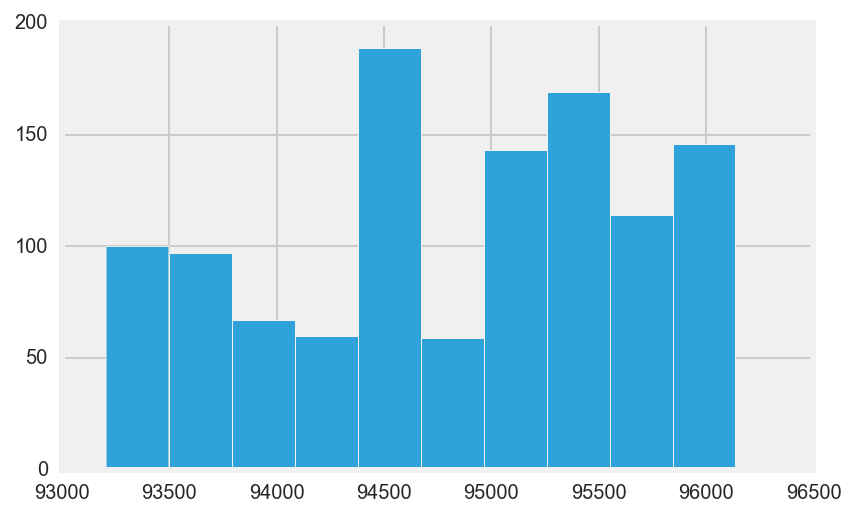

In [95]:
pge_q_num.ZipCode.hist()

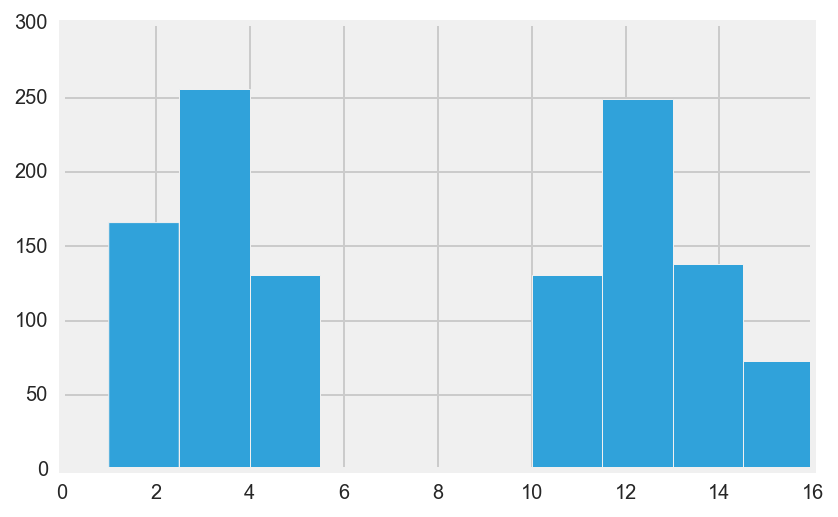

In [96]:
pge_q_num.zone.hist()

In [97]:
pge_q_num_corr  =  pge_q_num.corr()
pge_q_num_corr

ZipCode     Month      Year  CustomerClass  Combined  \
ZipCode         1.000000 -0.027023  0.001332       0.069113       NaN   
Month          -0.027023  1.000000 -0.076114       0.000042       NaN   
Year            0.001332 -0.076114  1.000000      -0.032339       NaN   
CustomerClass   0.069113  0.000042 -0.032339       1.000000       NaN   
Combined             NaN       NaN       NaN            NaN       NaN   
TotalCustomers -0.160473 -0.020807 -0.065188       0.297743       NaN   
TotalkWh       -0.146413  0.026166  0.029776      -0.279373       NaN   
AveragekWh     -0.083312  0.047209  0.050074      -0.566548       NaN   
zone            0.100040 -0.033735  0.059545       0.151186       NaN   
avg_temp       -0.477621 -0.017804  0.023419      -0.035405       NaN   

                TotalCustomers  TotalkWh  AveragekWh      zone  avg_temp  
ZipCode              -0.160473 -0.146413   -0.083312  0.100040 -0.477621  
Month                -0.020807  0.026166    0.047209 -0.033735 -0.017804  
Year                 -0.065188  0.029776    0.050074  0.059545  0.023419  
CustomerClass         0.297743 -0.279373   -0.566548  0.151186 -0.035405  
Combined                   NaN       NaN         NaN       NaN       NaN  
TotalCustomers        1.000000  0.489449   -0.248864 -0.138609  0.139562  
TotalkWh              0.489449  1.000000    0.373815 -0.125786  0.177740  
AveragekWh           -0.248864  0.373815    1.000000 -0.085801  0.076948  
zone                 -0.138609 -0.125786   -0.085801  1.000000  0.189722  
avg_temp              0.139562  0.177740    0.076948  0.189722  1.000000

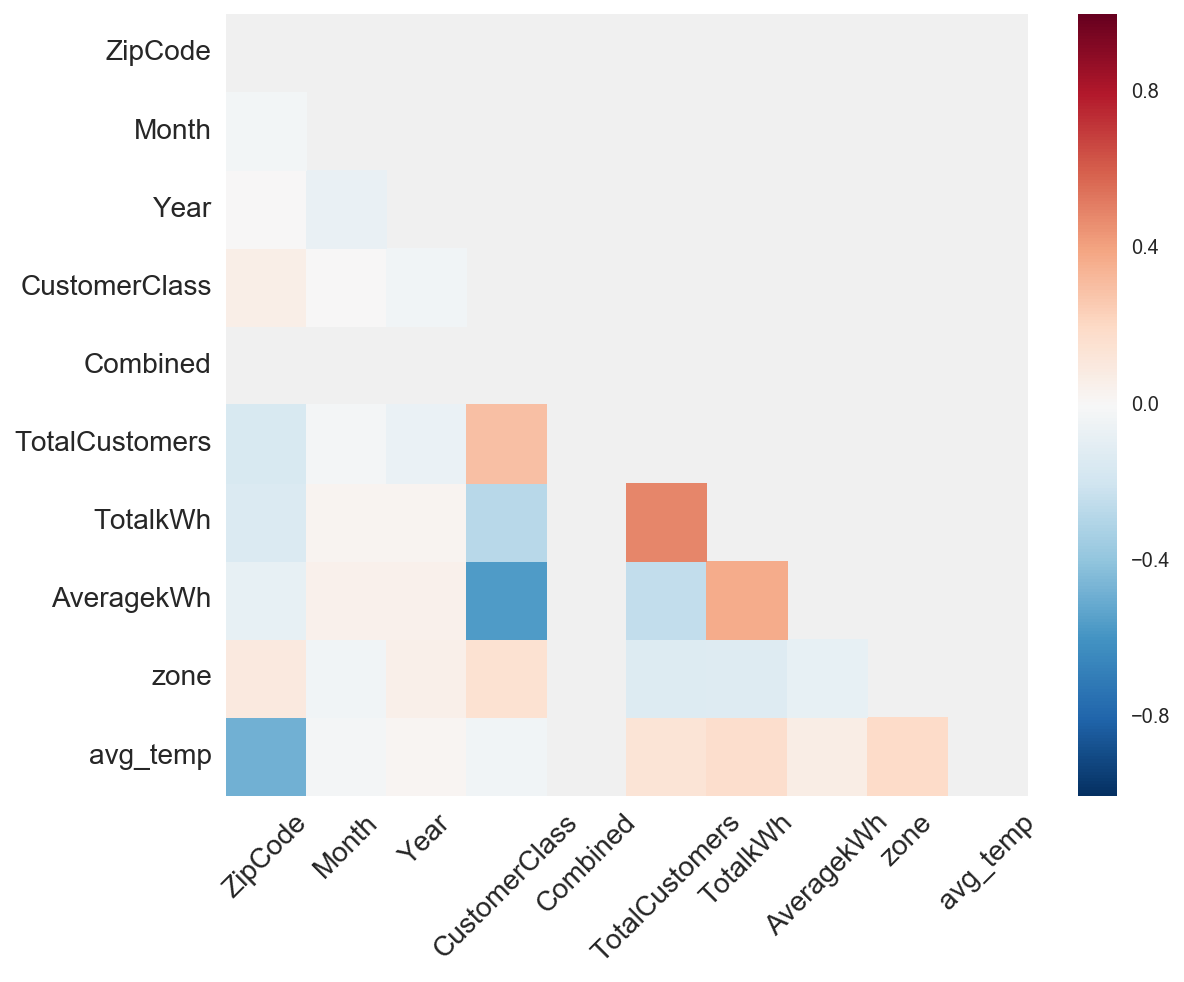

In [98]:
mask = np.zeros_like(pge_q_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(pge_q_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

Looking just at PG&E consumption data, we see that there is strong anti-correlation
between "TotalKWh" and "Month", and anti-corellation with "CustomerClass".

So interesting vars are TotalCustomers, TotalkWh, Month, zone, AveragekWh

In [100]:
sns.set(style="ticks", color_codes=True)

# This function does a pairplot across our variables

def electric_pairplotter(df, variables, sample_frac=0.3):
    # sample_frac lets us specify an amount of the data to sample for the plot.
    # this speeds up the function which can take awhile with the full data.
    
    # get the number of rows/data points:
    rows = df.shape[0]
    
    # get downsample indicies for the data, if specified
    if sample_frac < 1.0:
        sample_inds = np.random.choice(range(0,rows), 
                                       size=int(round(rows*sample_frac)), 
                                       replace=False).astype(int)
    
    # make the pairplot for the variables:
    pairs = sns.pairplot(df.iloc[sample_inds, :], 
                         vars=variables, 
                         hue="zone", 
                         palette=sns.xkcd_palette(['windows blue', 'amber']))

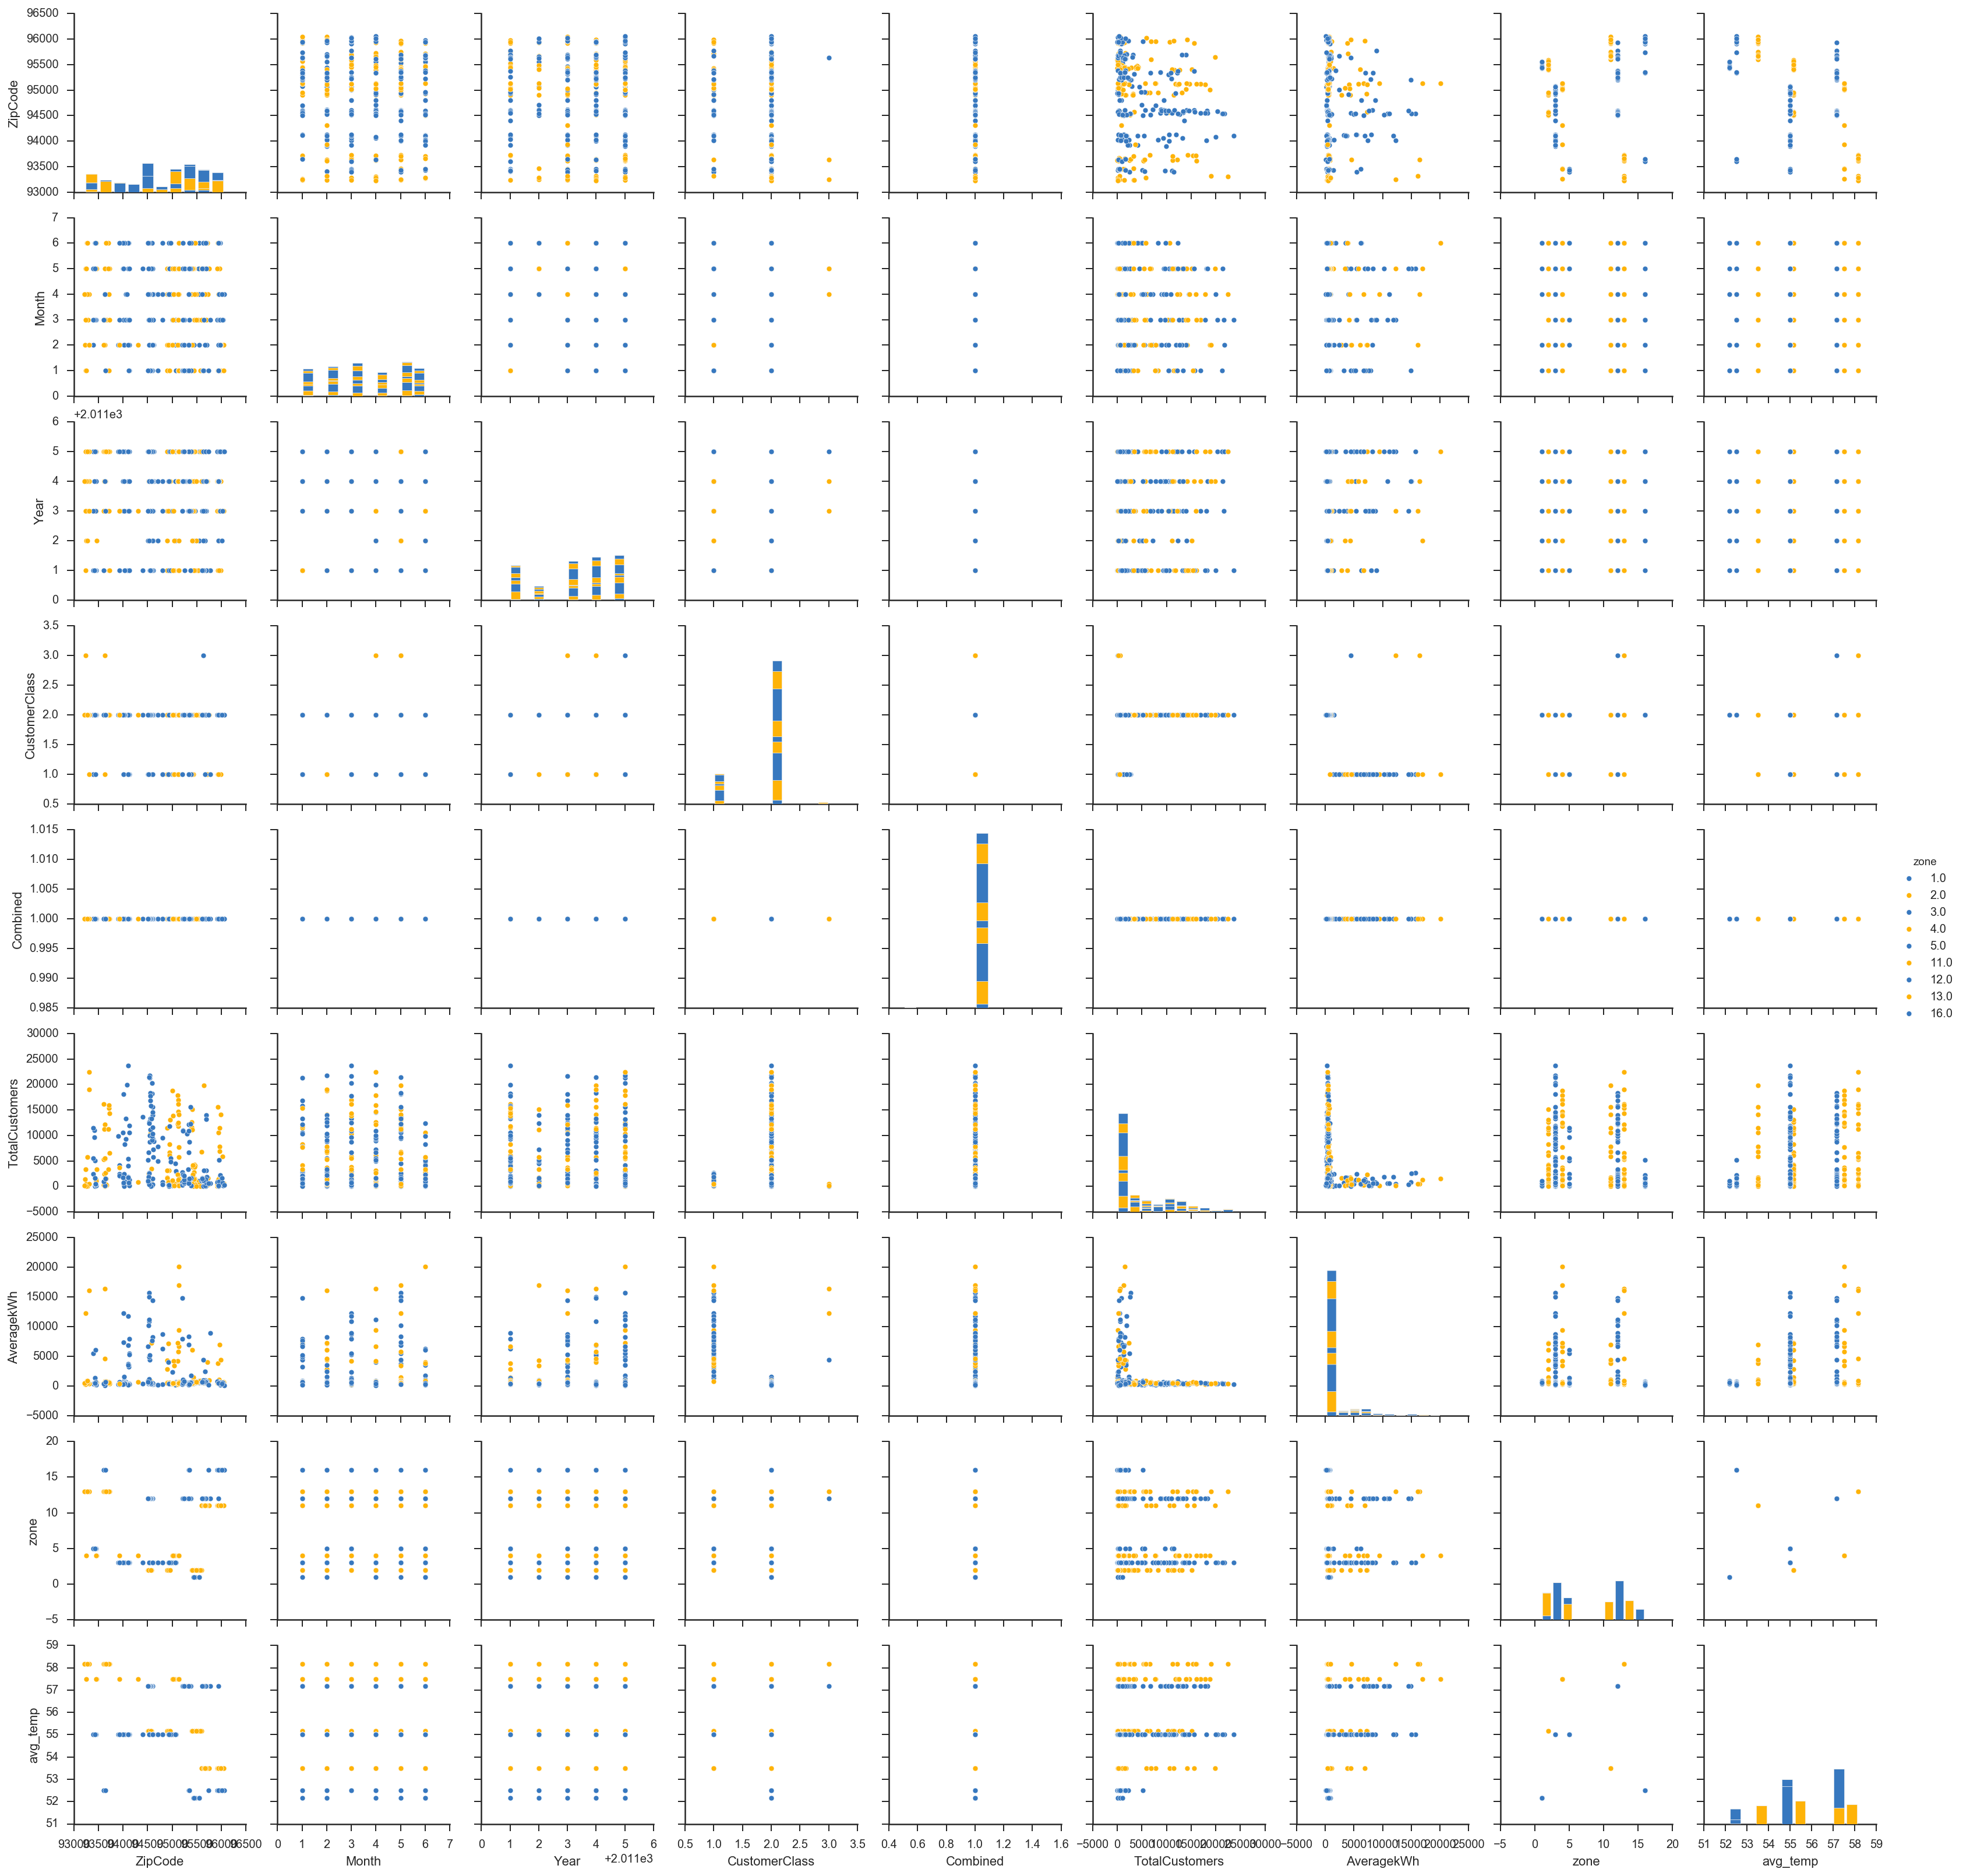

In [101]:
# get out the column variable names to put into the pairplotter function
colvars = [x for x in pge_q_num if x not in ['TotalkWh']]
electric_pairplotter(pge_q_num, colvars)

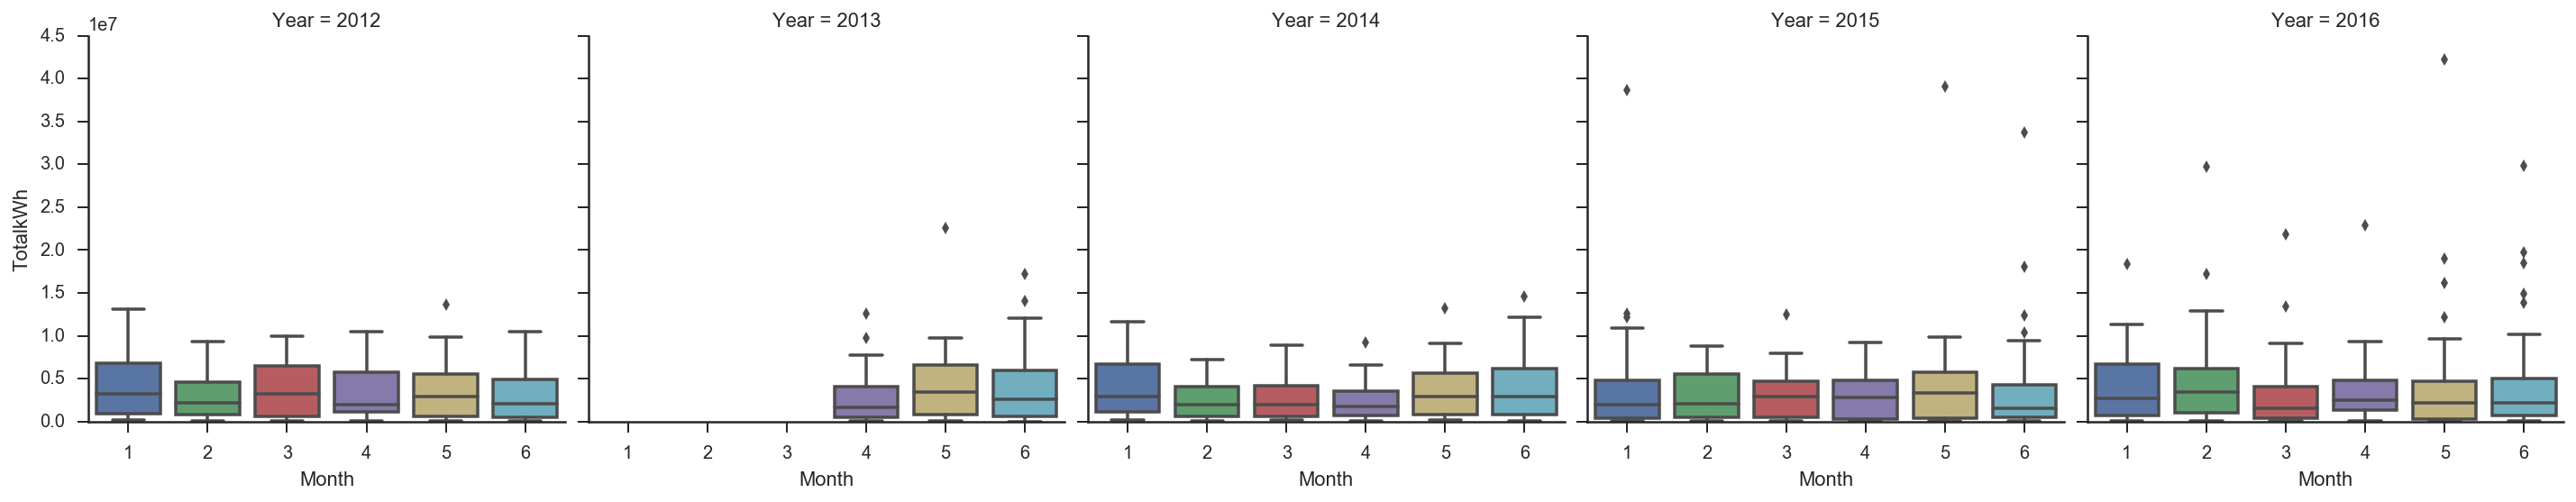

In [102]:
sns.factorplot(x='Month', y='TotalkWh',col='Year', kind='box', data=pge_q_num)

![](2.3.4.png)

Add avg_temp to the CA solar data frame. 

In [103]:
ca_solar_df_num['avg_temp'] = ca_solar_df_num['zone'].map(ca_2015_1_6_ave_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [104]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


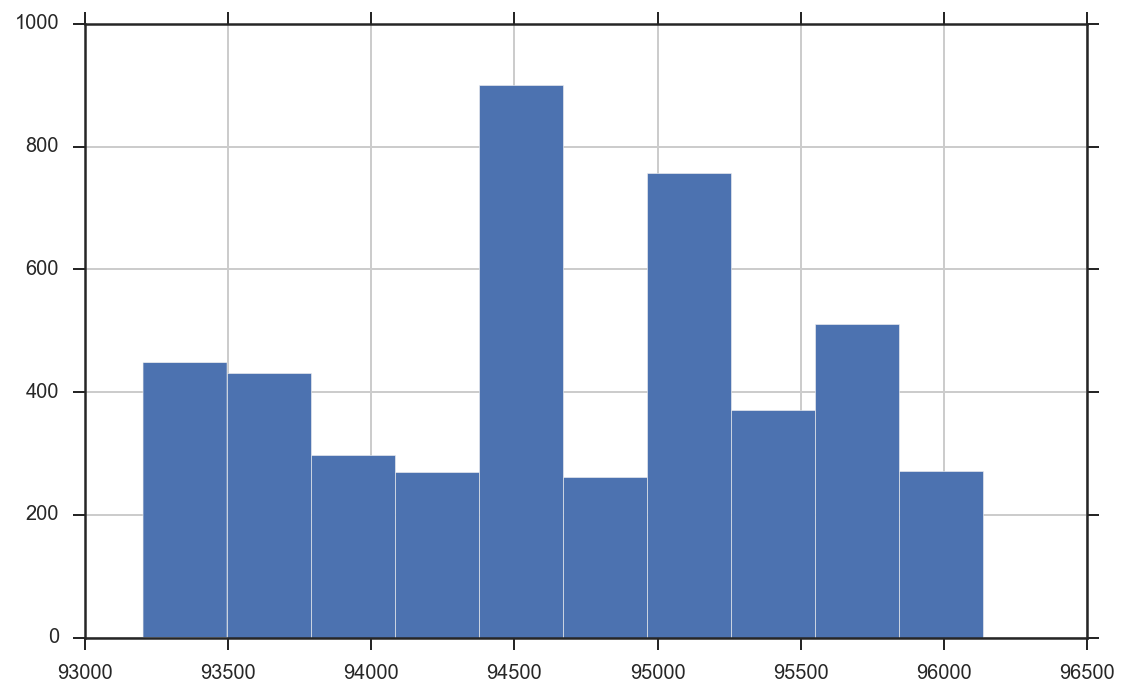

In [105]:
ca_solar_df_num.ZIP.hist()

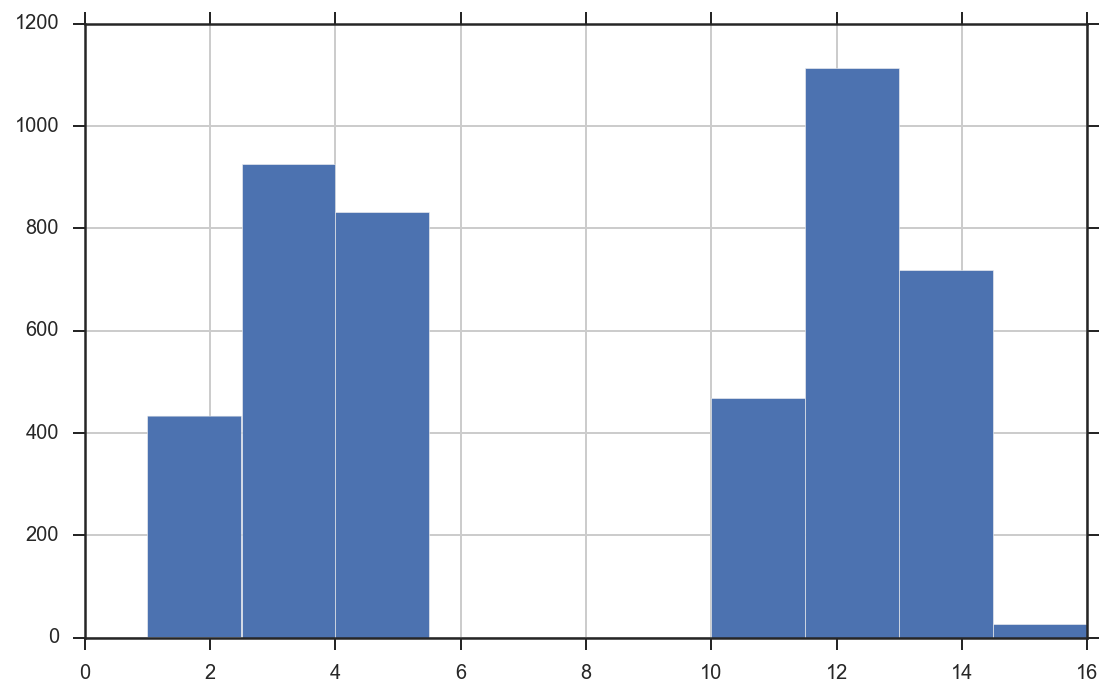

In [106]:
ca_solar_df_num.zone.hist()

In [107]:
ca_solar_df_num_corr  =  ca_solar_df_num.corr()
ca_solar_df_num_corr

Nameplate_Rating  CEC_PTC_Rating  \
Nameplate_Rating                             1.000000        0.999892   
CEC_PTC_Rating                               0.999892        1.000000   
CSI_Rating                                   0.987841        0.988074   
CEC_PTC_Rating_Single_Axis_Tracking          0.605686        0.608225   
CEC_PTC_Rating_Dual_Axis_Tracking           -0.000708       -0.000704   
CSI_Rating_Single_Axis_Tracking              0.604919        0.607109   
CSI_Rating_Dual_Axis_Tracking               -0.000703       -0.000698   
ZIP                                         -0.037877       -0.037988   
zone                                         0.032614        0.032532   
avg_temp                                     0.038961        0.039158   

                                     CSI_Rating  \
Nameplate_Rating                       0.987841   
CEC_PTC_Rating                         0.988074   
CSI_Rating                             1.000000   
CEC_PTC_Rating_Single_Axis_Tracking    0.713635   
CEC_PTC_Rating_Dual_Axis_Tracking     -0.000649   
CSI_Rating_Single_Axis_Tracking        0.714478   
CSI_Rating_Dual_Axis_Tracking         -0.000644   
ZIP                                   -0.041128   
zone                                   0.038013   
avg_temp                               0.042656   

                                     CEC_PTC_Rating_Single_Axis_Tracking  \
Nameplate_Rating                                                0.605686   
CEC_PTC_Rating                                                  0.608225   
CSI_Rating                                                      0.713635   
CEC_PTC_Rating_Single_Axis_Tracking                             1.000000   
CEC_PTC_Rating_Dual_Axis_Tracking                              -0.001039   
CSI_Rating_Single_Axis_Tracking                                 0.998567   
CSI_Rating_Dual_Axis_Tracking                                  -0.001038   
ZIP                                                            -0.028211   
zone                                                            0.032043   
avg_temp                                                        0.030229   

                                     CEC_PTC_Rating_Dual_Axis_Tracking  \
Nameplate_Rating                                             -0.000708   
CEC_PTC_Rating                                               -0.000704   
CSI_Rating                                                   -0.000649   
CEC_PTC_Rating_Single_Axis_Tracking                          -0.001039   
CEC_PTC_Rating_Dual_Axis_Tracking                             1.000000   
CSI_Rating_Single_Axis_Tracking                              -0.001025   
CSI_Rating_Dual_Axis_Tracking                                 0.999990   
ZIP                                                          -0.010080   
zone                                                          0.019898   
avg_temp                                                      0.003188   

                                     CSI_Rating_Single_Axis_Tracking  \
Nameplate_Rating                                            0.604919   
CEC_PTC_Rating                                              0.607109   
CSI_Rating                                                  0.714478   
CEC_PTC_Rating_Single_Axis_Tracking                         0.998567   
CEC_PTC_Rating_Dual_Axis_Tracking                          -0.001025   
CSI_Rating_Single_Axis_Tracking                             1.000000   
CSI_Rating_Dual_Axis_Tracking                              -0.001024   
ZIP                                                        -0.028683   
zone                                                        0.032955   
avg_temp                                                    0.031040   

                                     CSI_Rating_Dual_Axis_Tracking       ZIP  \
Nameplate_Rating                                         -0.000703 -0.037877   
CEC_PTC_Rating                                           -0.000698

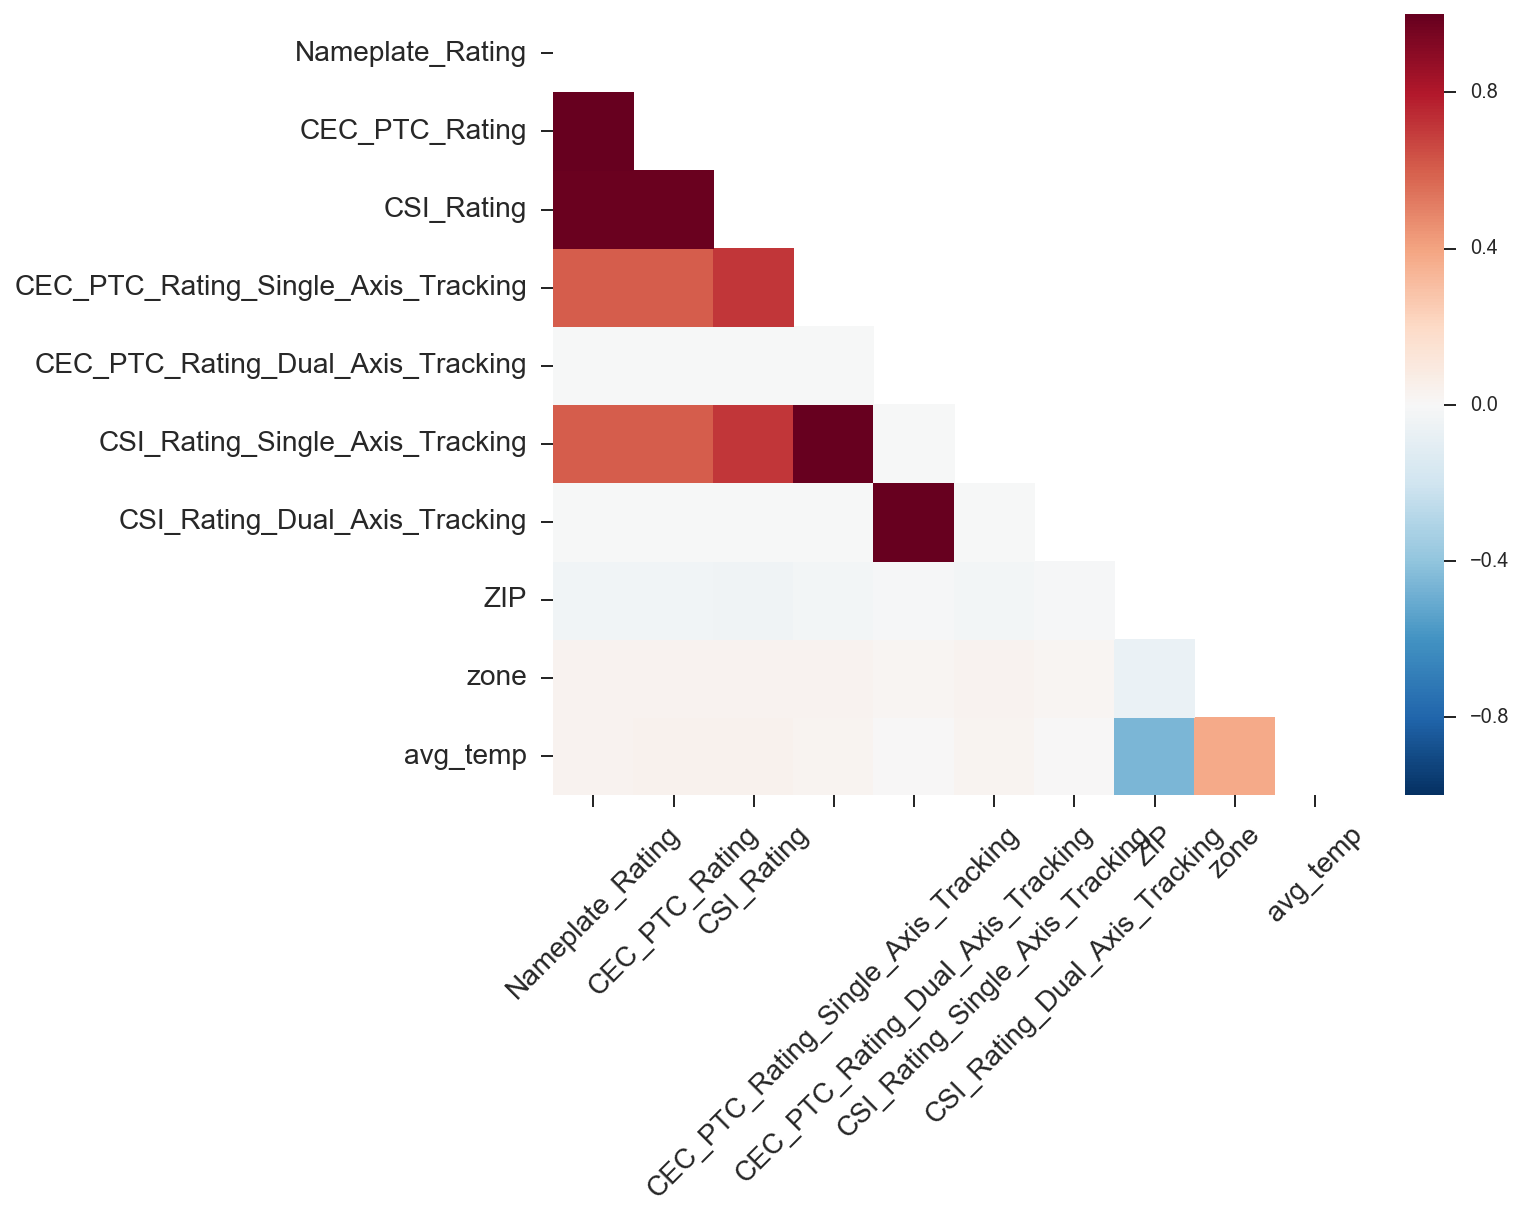

In [108]:
mask = np.zeros_like(ca_solar_df_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(ca_solar_df_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

So interesting vars are Nameplate Rating, CEC PTC Rating, CSI Rating, zone, avg_temp

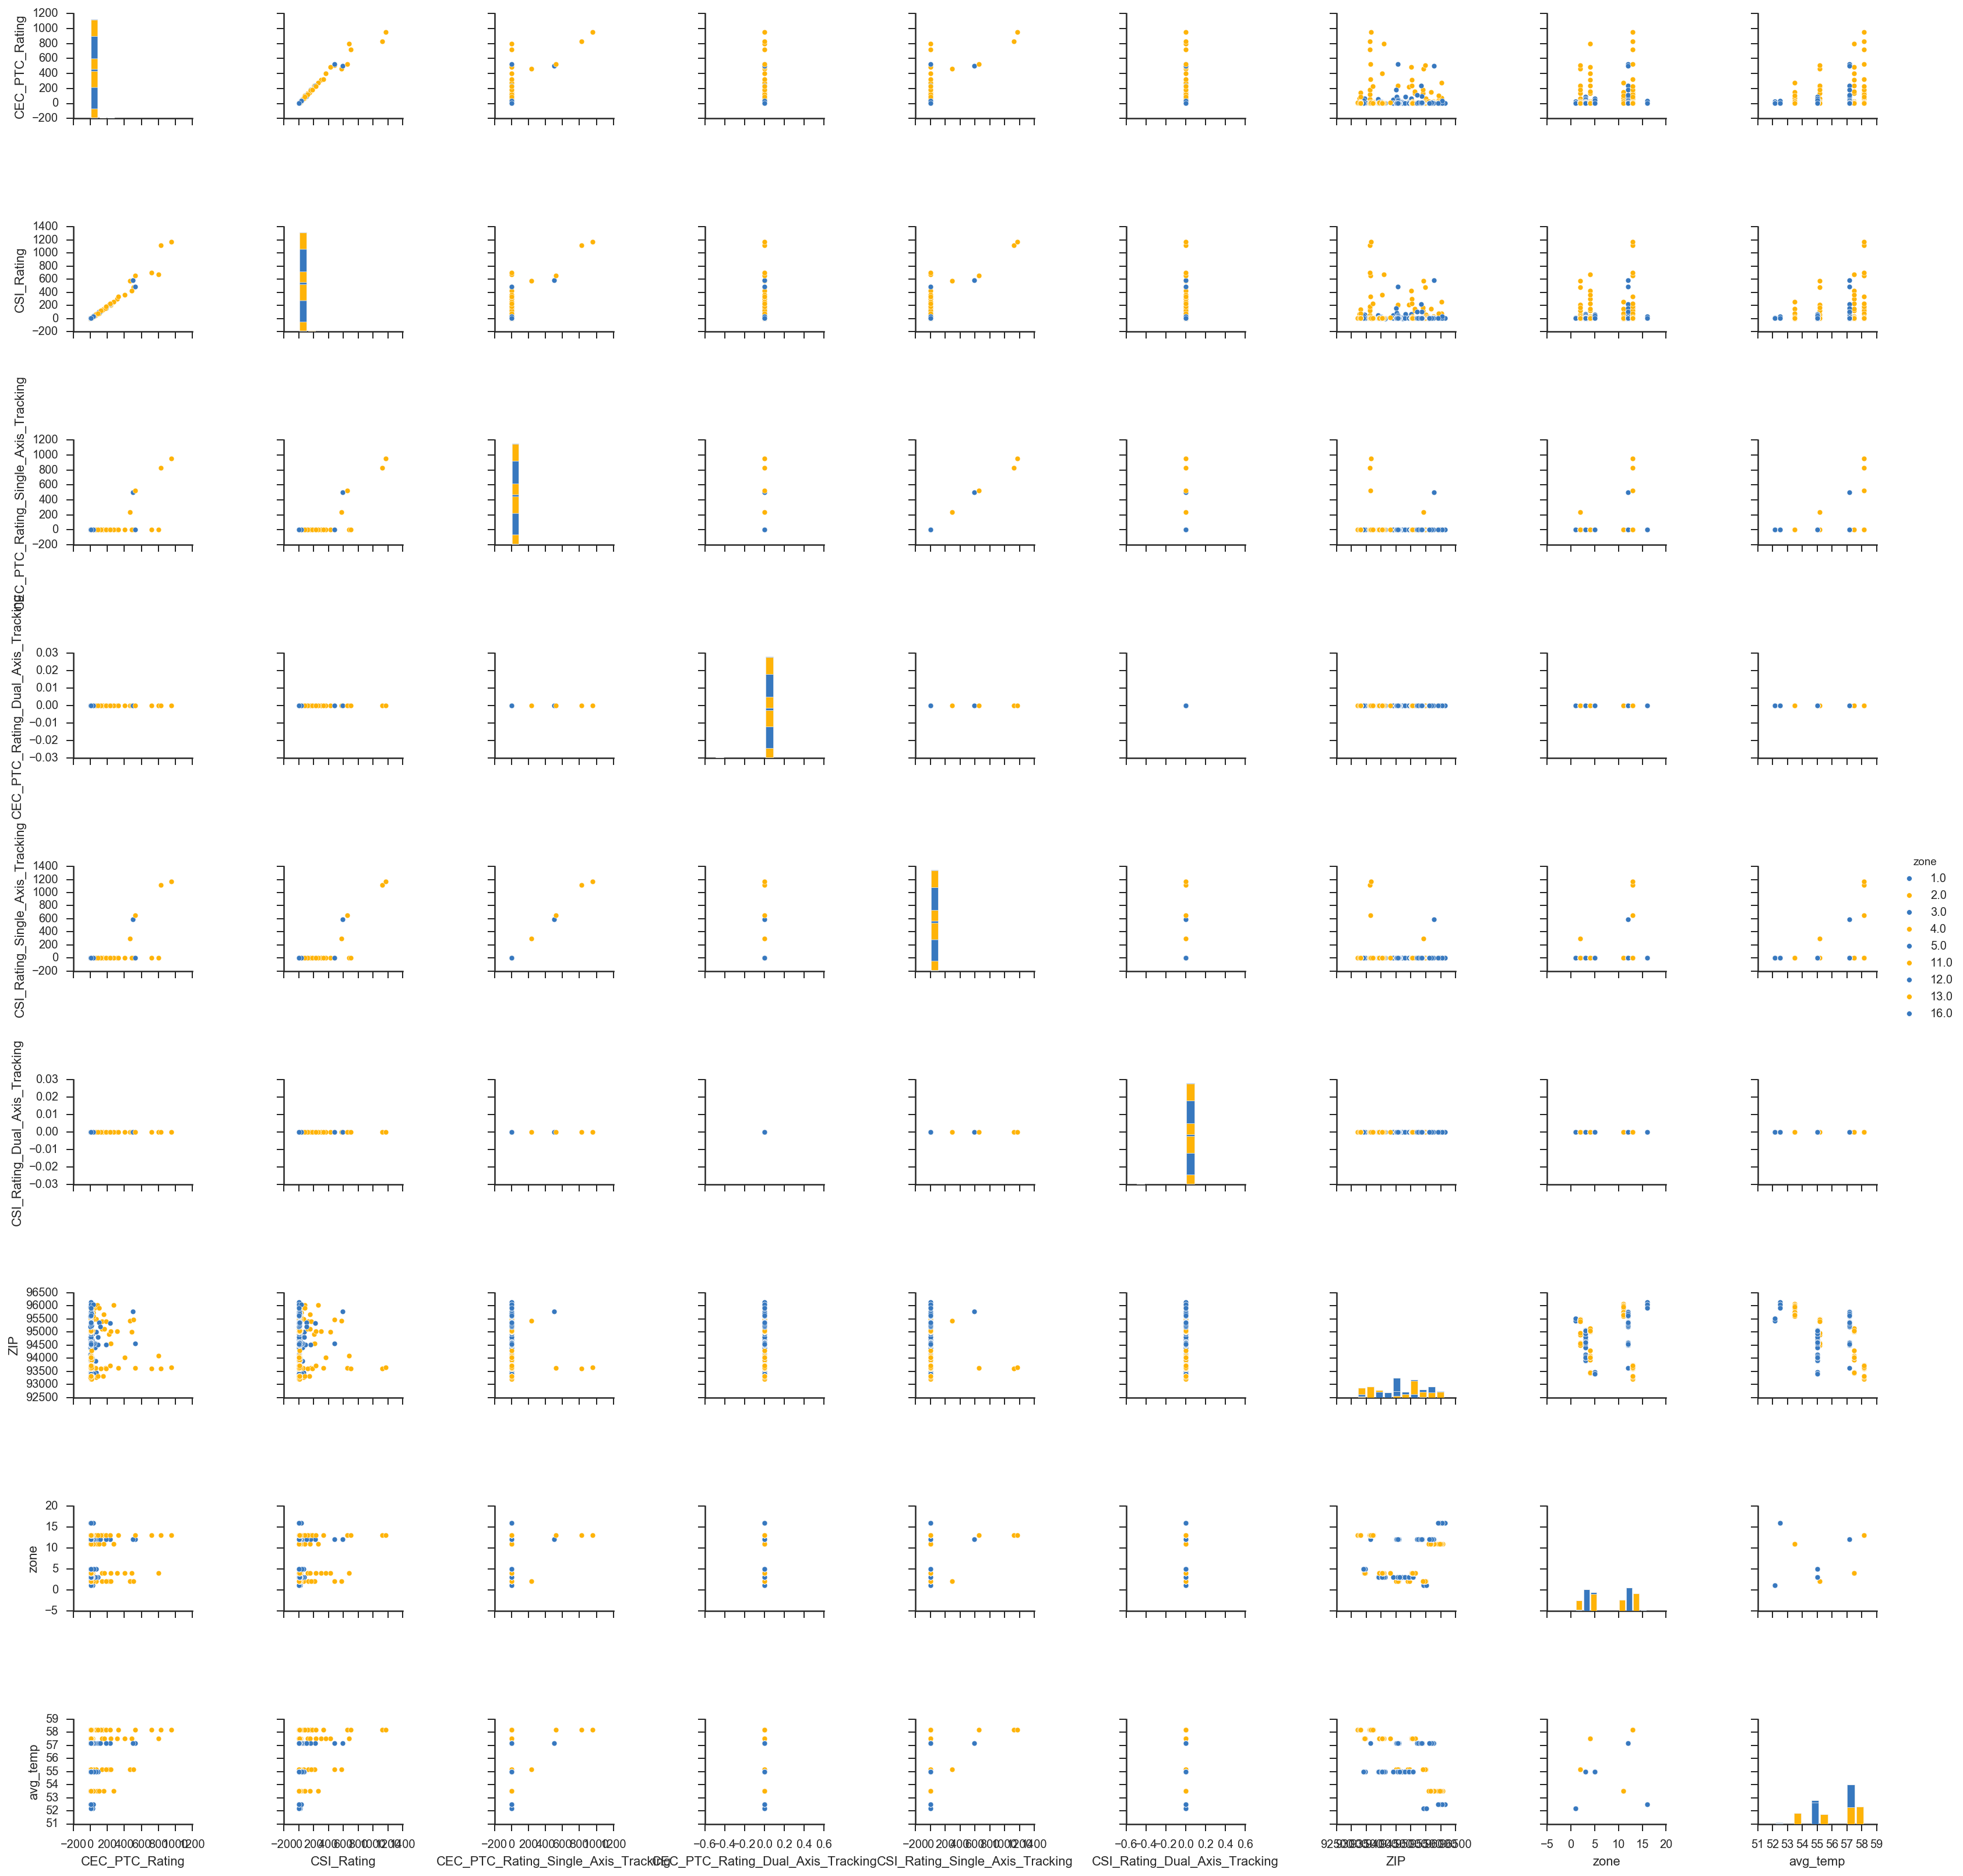

In [110]:
colvars = [x for x in ca_solar_df_num if x not in ['Nameplate_Rating']]
electric_pairplotter(ca_solar_df_num, colvars)

<h2> 3. Let's do now some analysis. 
<br>
<br>
3.1 First, we do some linear regression. </h2>

In [111]:
target = 'TotalkWh'
non_target_cols = ['Month', 'TotalCustomers', 'ZipCode', 'CustomerClass', 'zone', 
                   'avg_temp']
#non_target_cols = ['AveragekWh', 'Month', 'TotalCustomers', 'CustomerClass', 'zone']
                   
#TotalCustomers, TotalkWh, Month, zone, AveragekWh
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print formula_simple

TotalkWh ~ Month + TotalCustomers + ZipCode + CustomerClass + zone + avg_temp -1


In [112]:
Y, X = patsy.dmatrices(formula_simple, data=pge_q_num)

In [113]:
simple_feature_names = X.design_info.column_names

In [114]:
pge_q_num.head(3)

ZipCode  Month  Year  CustomerClass  Combined  TotalCustomers  \
933     94561      4  2013              2         1         12037.0   
2588    93249      5  2013              2         1           513.0   
2381    95972      4  2013              2         1            83.0   

       TotalkWh  AveragekWh  zone   avg_temp  
933   7017793.0       583.0  12.0  57.166667  
2588   297597.0       580.0  13.0  58.166667  
2381    62061.0       748.0  11.0  53.500000

In [115]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(pge_q_num)

In [116]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xn, Y, cv=10)

print linreg_scores
print np.mean(linreg_scores)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


This score is exactly 1. There must be some correlation between the vars.
Let me try a different formula, with categorical vars.

In [117]:
formula_simple = 'AveragekWh ~ C(TotalCustomers) + Month + Year + C(CustomerClass) + C(zone) + C(avg_temp) -1'
print formula_simple

AveragekWh ~ C(TotalCustomers) + Month + Year + C(CustomerClass) + C(zone) + C(avg_temp) -1


In [118]:
X, Y = patsy.dmatrices(formula_simple, data=pge_q_num)

In [119]:
simple_feature_names = X.design_info.column_names

In [120]:
ss = StandardScaler()
Xn = ss.fit_transform(pge_q_num)

In [121]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xn, Y, cv=10)

print linreg_scores
print np.mean(linreg_scores)
linreg_fit = linreg.fit(Xn, Y)

[ 0.75833048  0.74283105  0.74622758  0.73409111  0.75014094  0.72722809
  0.75777909  0.74738787  0.71893807  0.73593024]
0.741888450647


This is more reasonable. The AWS result with the full data set is 
<pre>
[ 0.41476044  0.41889318  0.75286632  0.4200982   0.73609376  0.44542479
  0.42138057  0.42063523  0.50239673  0.43774385
0.497029308677
</pre>

<h2> 3.2 Now Ridge with cross-validation </h2>

In [122]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn, Y)

print optimal_ridge.alpha_

2.24780583355


In [123]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn, Y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.75830259  0.74280311  0.74625076  0.7341379   0.75010597  0.72719175
  0.75777351  0.74738261  0.71901702  0.7359606 ]
0.741892583


OK,  Ridge gives now good answers w cross validation. 

<h2> 3.3 Let's plot the results.  </h2>

In [124]:

def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()


    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)        
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list (first element of the .coef_ attribute)
        coefs.append(ridge_reg.coef_[0])
        
    return coefs

In [125]:
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()

In [126]:
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

In [127]:
from ipywidgets import *
from IPython.display import display

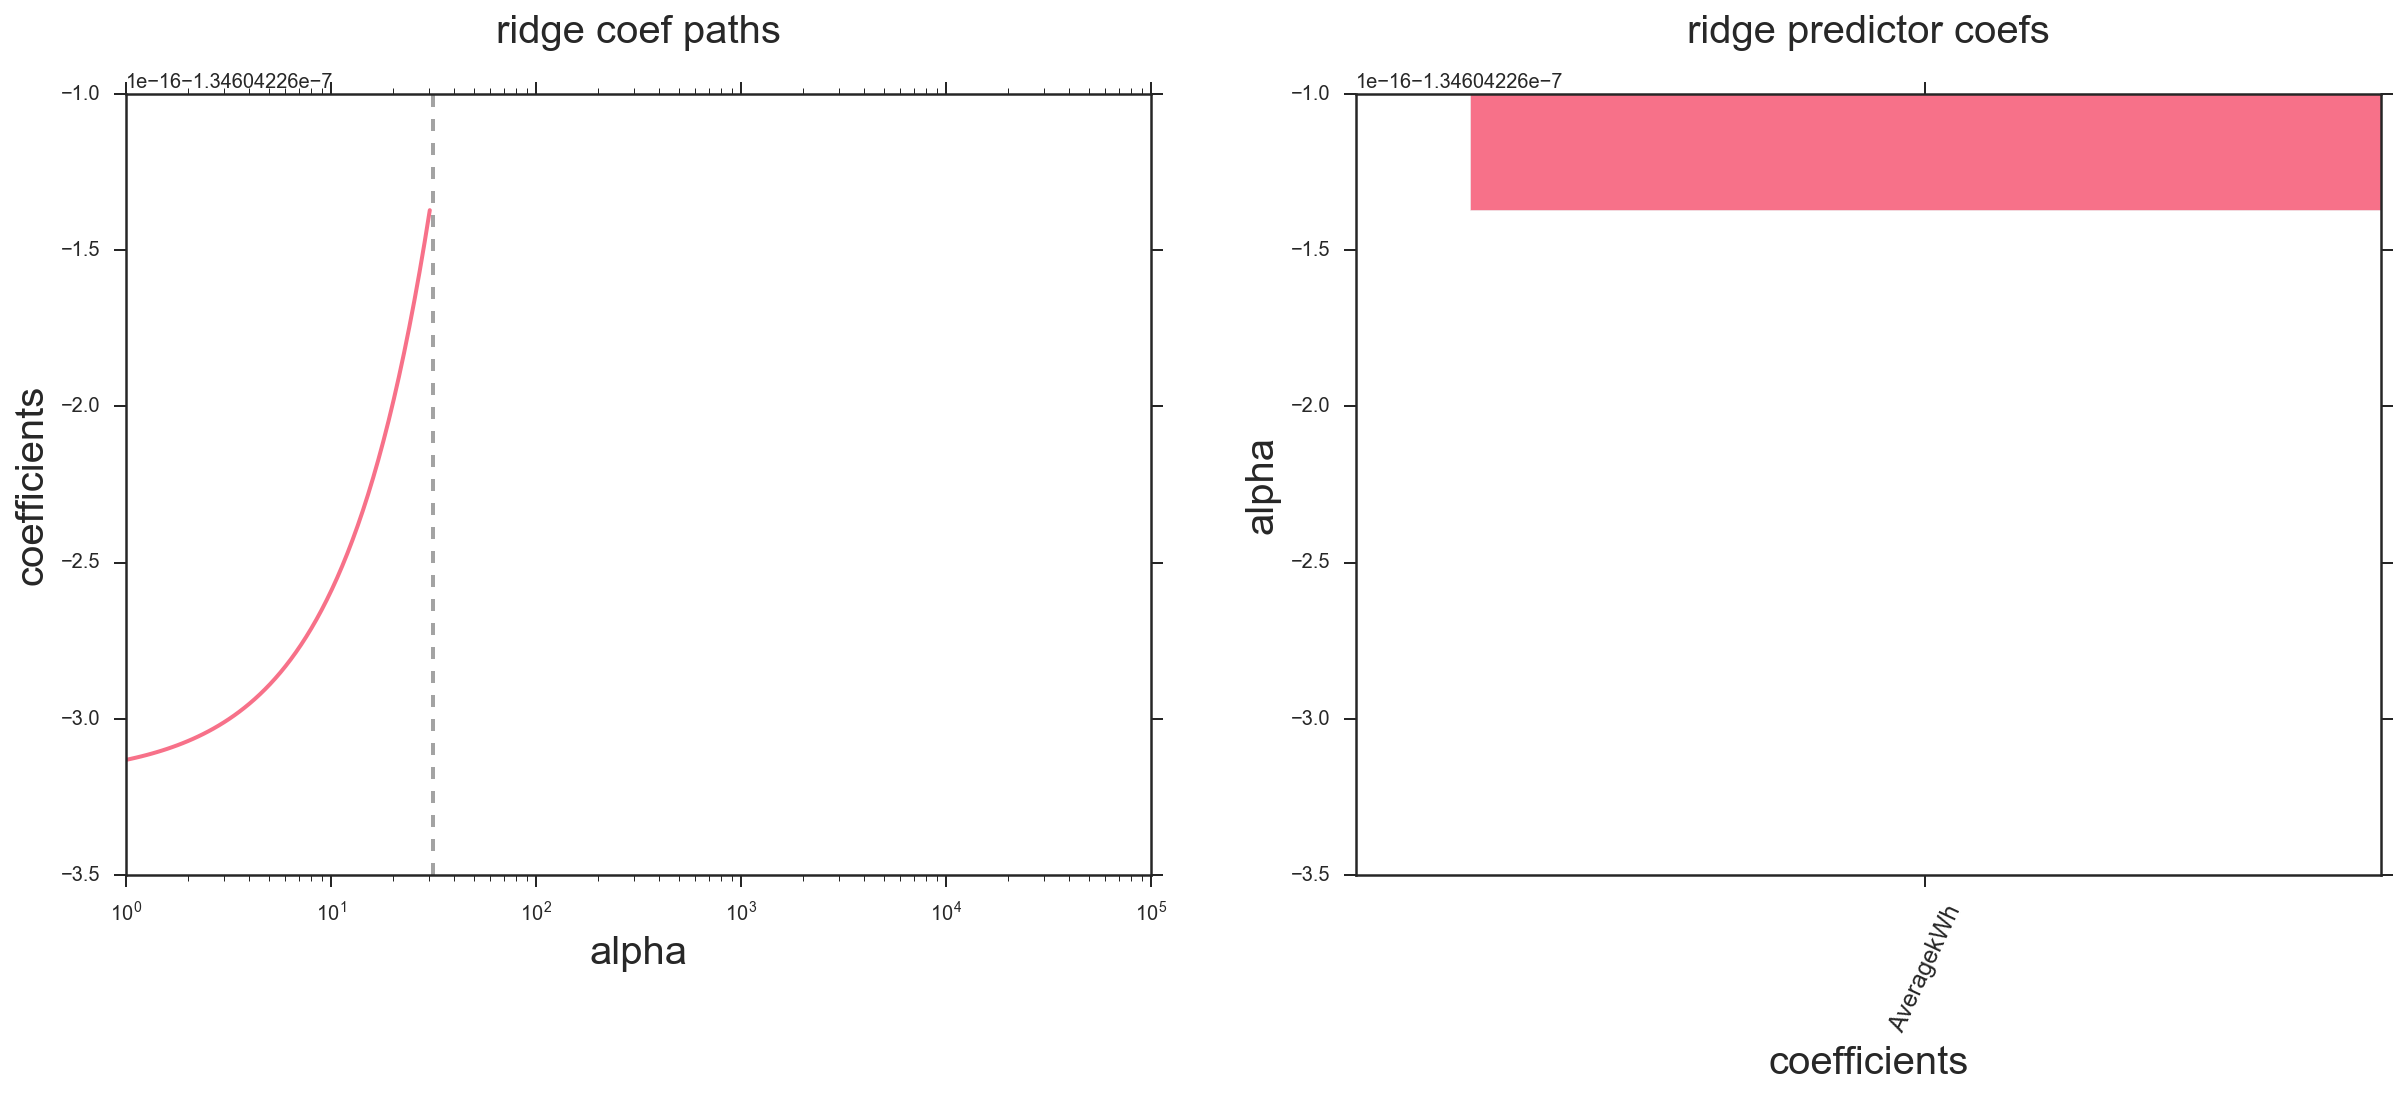

<function __main__.ridge_plot_runner>

In [128]:
def ridge_plot_runner(log_of_alpha=1.5):
    coef_plotter(r_alphas, r_coefs, simple_feature_names, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))

Since I did not get a good analysis with Ridge, I will go now to Elastic Net. 

<h2> 3.4 Let's look at ElasticNet now.  </h2>

In [129]:
target = 'TotalkWh'
non_target_cols = ['AveragekWh', 'Month', 'TotalCustomers', 'ZipCode', 'CustomerClass', 'zone', 
                   'avg_temp']                   
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print formula_simple

TotalkWh ~ AveragekWh + Month + TotalCustomers + ZipCode + CustomerClass + zone + avg_temp -1


In [130]:
Y, X = patsy.dmatrices(formula_simple, data=pge_q_num)

In [131]:
simple_feature_names = X.design_info.column_names

In [132]:
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    score = []
    l1_ratios = alphas

    #enet_reg = ElasticNetCV()
    enet_reg = ElasticNet()
    for a in alphas:
        #enet_reg.set_params(l1_ratio=l1_ratios, n_alphas=100, cv=5,verbose=1)
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        score.append(enet_reg.score(X,Y))
        coefs.append(enet_reg.coef_)
        
    return np.mean(score), coefs

In [133]:
enet_alphas = np.arange(0, 3.0, 0.05)
enet_score, enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [134]:
print "enet score is: ", enet_score

enet score is:  0.513767372139


Not great, but not too bad. 

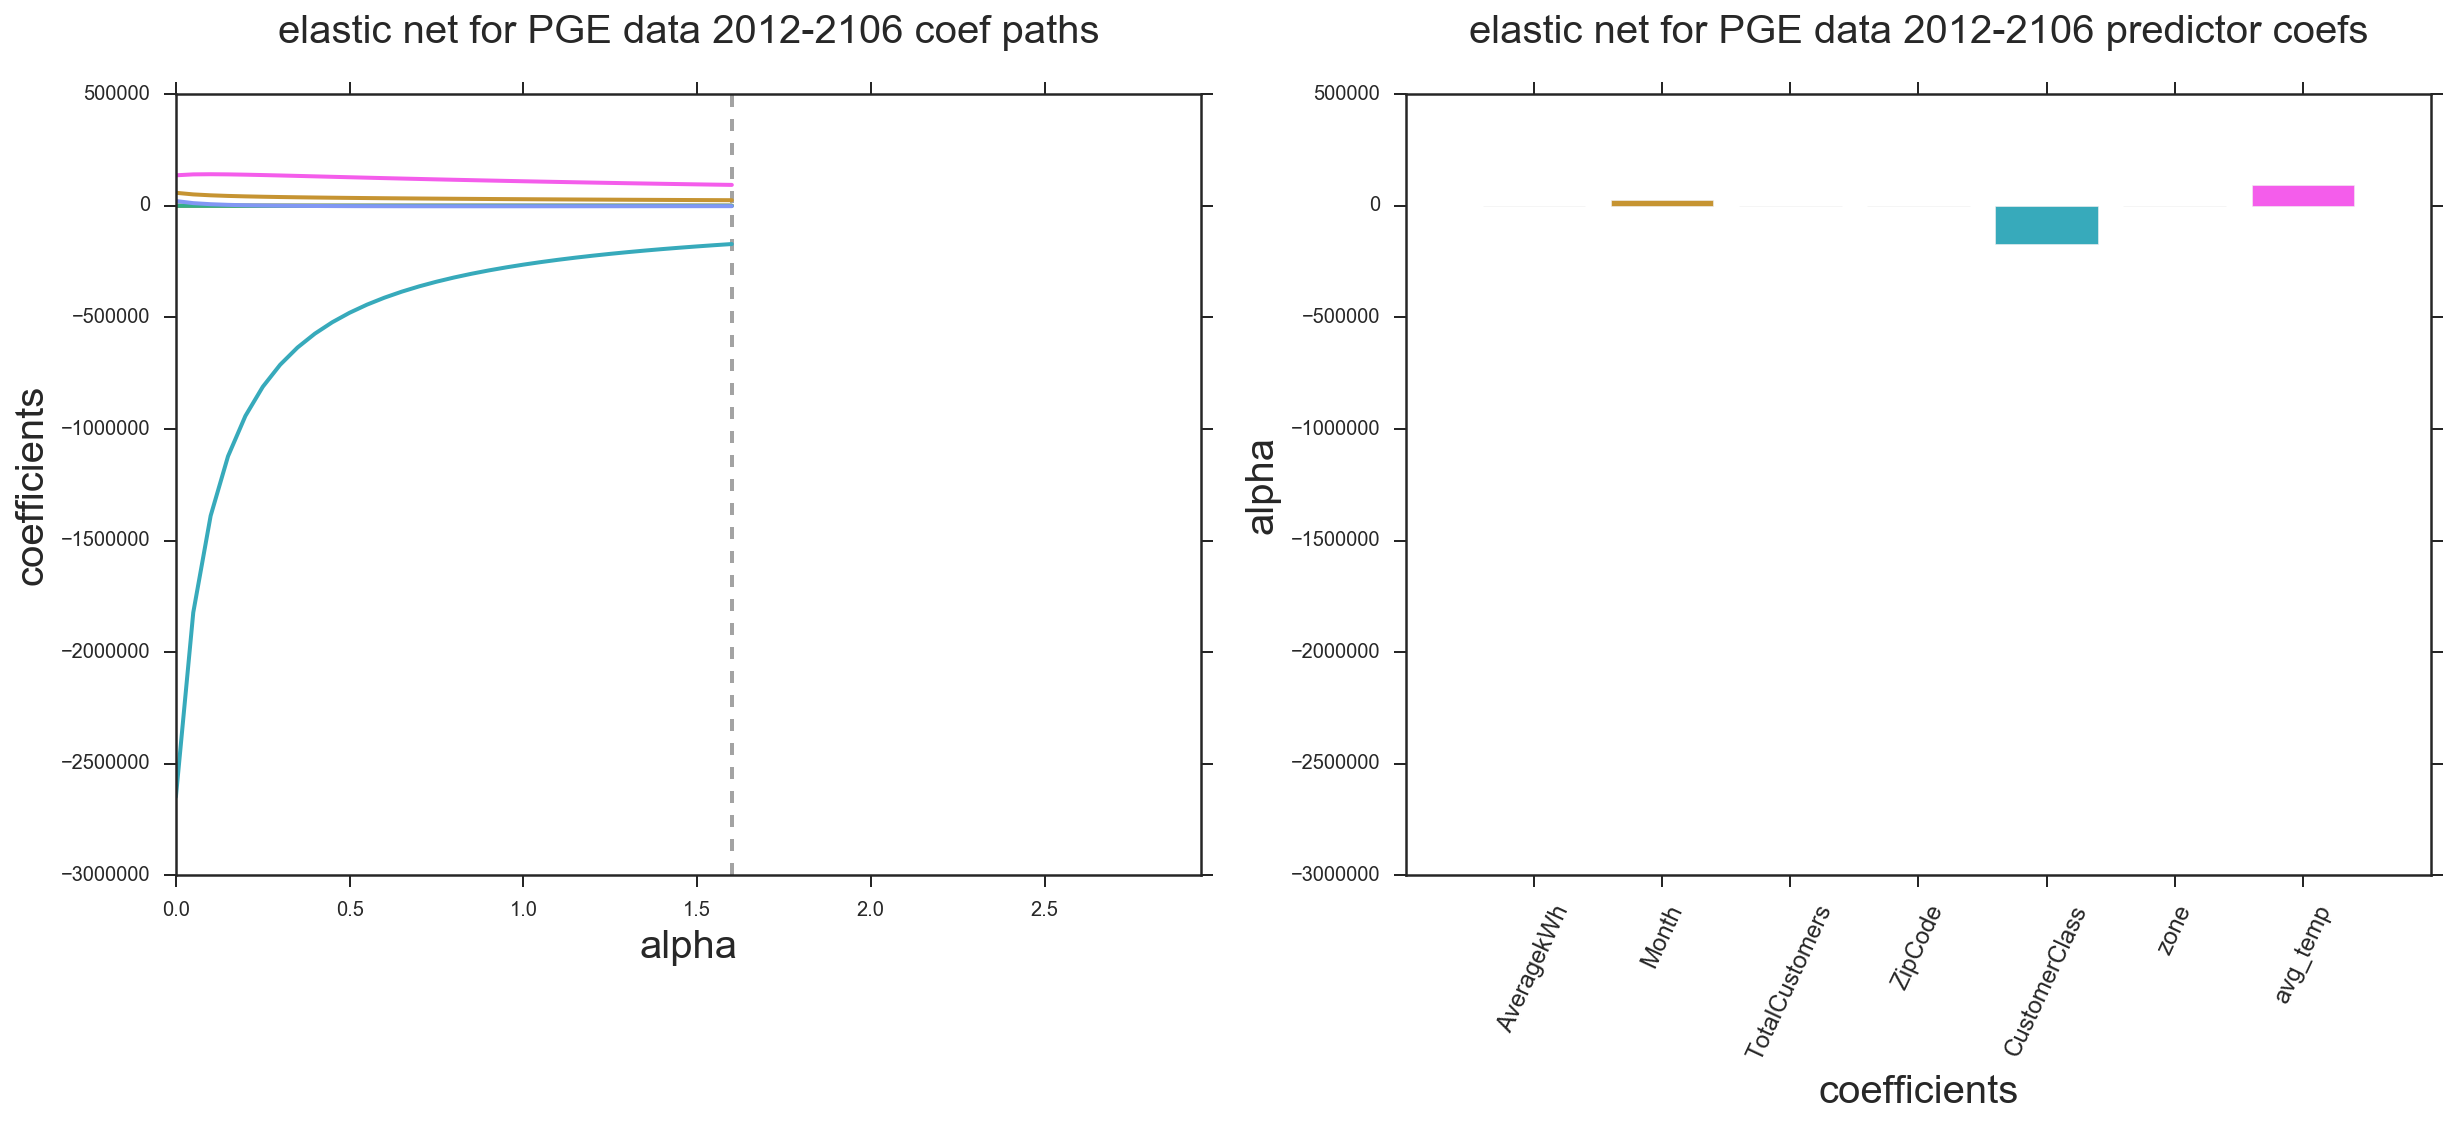

<function __main__.enet_plot_runner>

In [135]:
def enet_plot_runner(alpha=1.60):
    coef_plotter(enet_alphas, enet_coefs, simple_feature_names, alpha, 
                 regtype='elastic net for PGE data 2012-2106')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

![](3.4.1.2.png)

Looking just at PG&E consumption data, we see that 'TotalkWh' correlates with "zone" and "avg_temp" anti-correlation between "TotalKWh" and "Month", and anti-corellation with "CustomerClass".

This result seems  good. Let me do a time series analysis, see if we get as good are result there.
The data is monthly, Jan - Jun for 5 years, 2012-2016, so it might be ameanable to time series analysis. 

<h2> 3.5 Time series analysis. </h2>

Let me do a time series analysis, since I have data from 2012 until 2016. 

In [137]:
avgkwh_diff  = pge_q_num.AveragekWh.diff()

In [138]:
avgkwh_diff.dropna(inplace=True)

In [139]:
totalkwh_diff = pge_q_num.TotalkWh.diff()

In [140]:
totalkwh_diff.dropna(inplace=True)

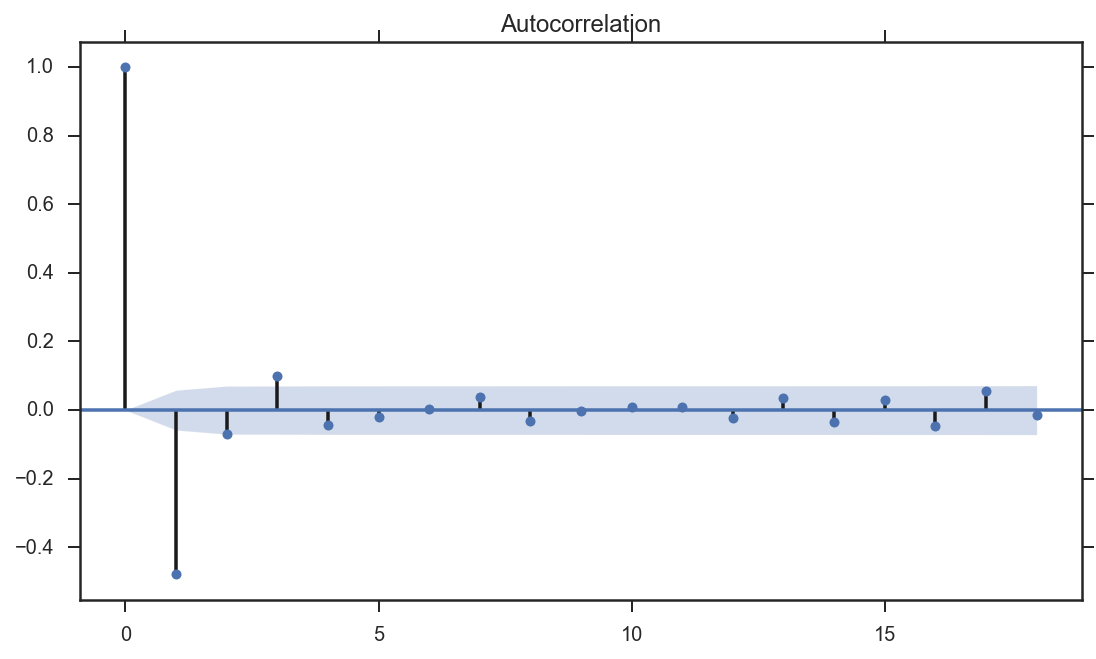

In [141]:
# pick the lag value at 18 = 6 * 3 the total number of data points we have for each avg kwh, total kwh
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(avgkwh_diff, lags=18, ax=ax)
plt.show()

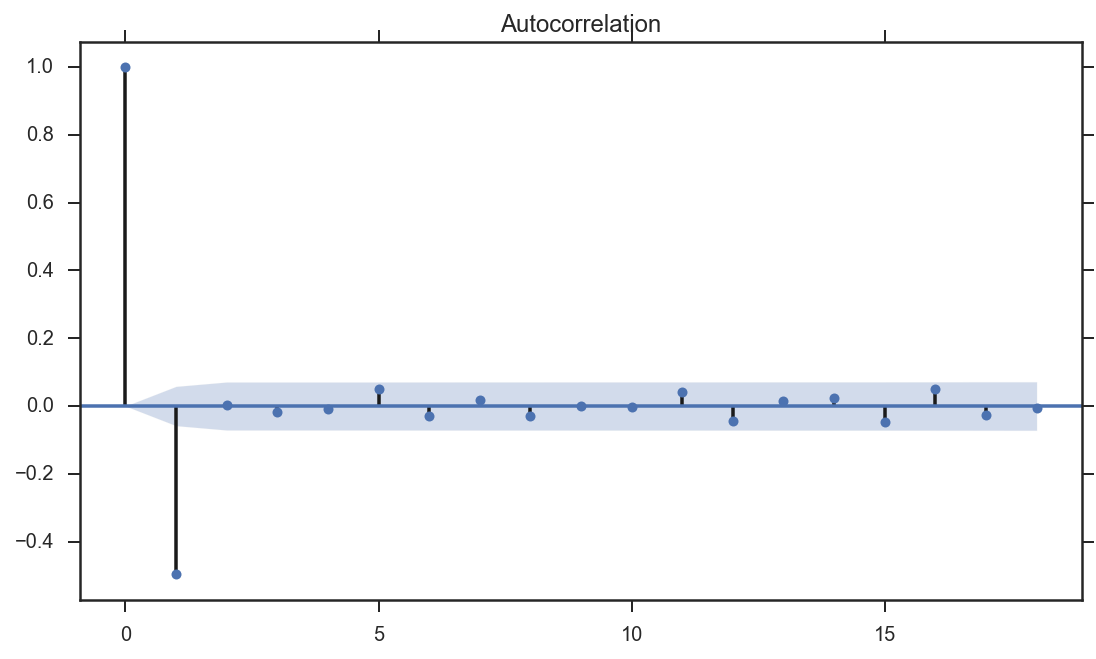

In [142]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(totalkwh_diff, lags=18, ax=ax)
plt.show()

In [143]:
ar1 = ARMA(avgkwh_diff.values, (1,0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1143
Model:                     ARMA(1, 0)   Log Likelihood              -11446.017
Method:                       css-mle   S.D. of innovations           5404.358
Date:                Fri, 14 Oct 2016   AIC                          22898.034
Time:                        10:52:10   BIC                          22913.158
Sample:                             0   HQIC                         22903.744
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4751    108.189      0.004      0.996      -211.572   212.522
ar.L1.y       -0.4780      0.026    -18.413      0.000        -0.529    -0.427
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0923           +0.0000j            2.0923            0.5000
-----------------------------------------------------------------------------
"""

In [144]:
ar2 = ARMA(totalkwh_diff.values, (1,0)).fit()
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1143
Model:                     ARMA(1, 0)   Log Likelihood              -19264.344
Method:                       css-mle   S.D. of innovations        5051176.043
Date:                Fri, 14 Oct 2016   AIC                          38534.688
Time:                        10:52:11   BIC                          38549.812
Sample:                             0   HQIC                         38540.399
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -5121.6238   9.99e+04     -0.051      0.959     -2.01e+05  1.91e+05
ar.L1.y       -0.4967      0.026    -19.343      0.000        -0.547    -0.446
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0132           +0.0000j            2.0132            0.5000
-----------------------------------------------------------------------------
"""

In [145]:
r2_score(avgkwh_diff, ar1.fittedvalues)

0.22883615078754838

On AWS, I get: 0.46362425034127097

In [146]:
r2_score(totalkwh_diff, ar2.fittedvalues)

0.24638053291302353

On AWS, I get: 0.21200243459953971

These results are not as high as the linear regression, but are probably more realistic.

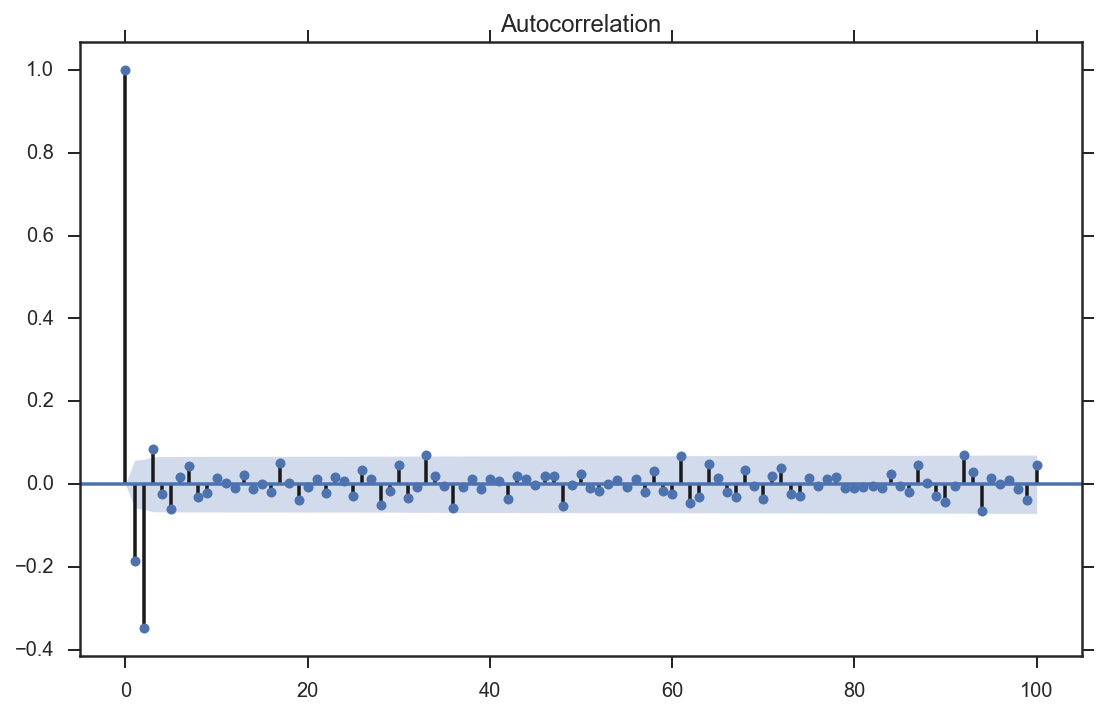

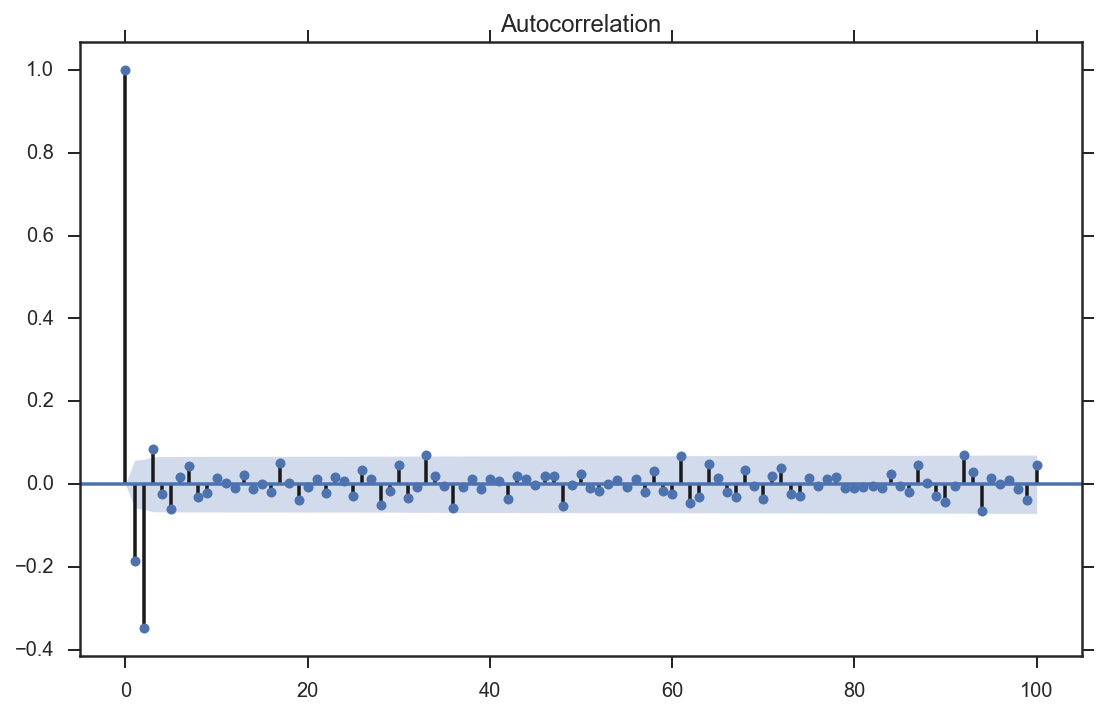

In [147]:
plot_acf(ar1.resid, lags=100)

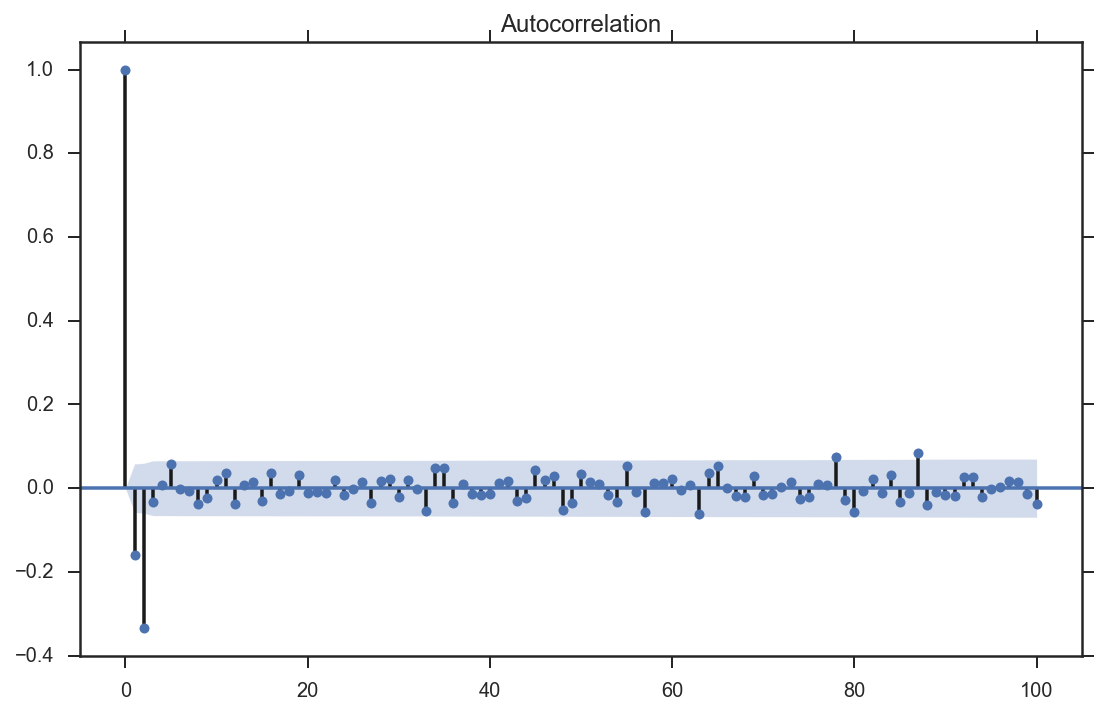

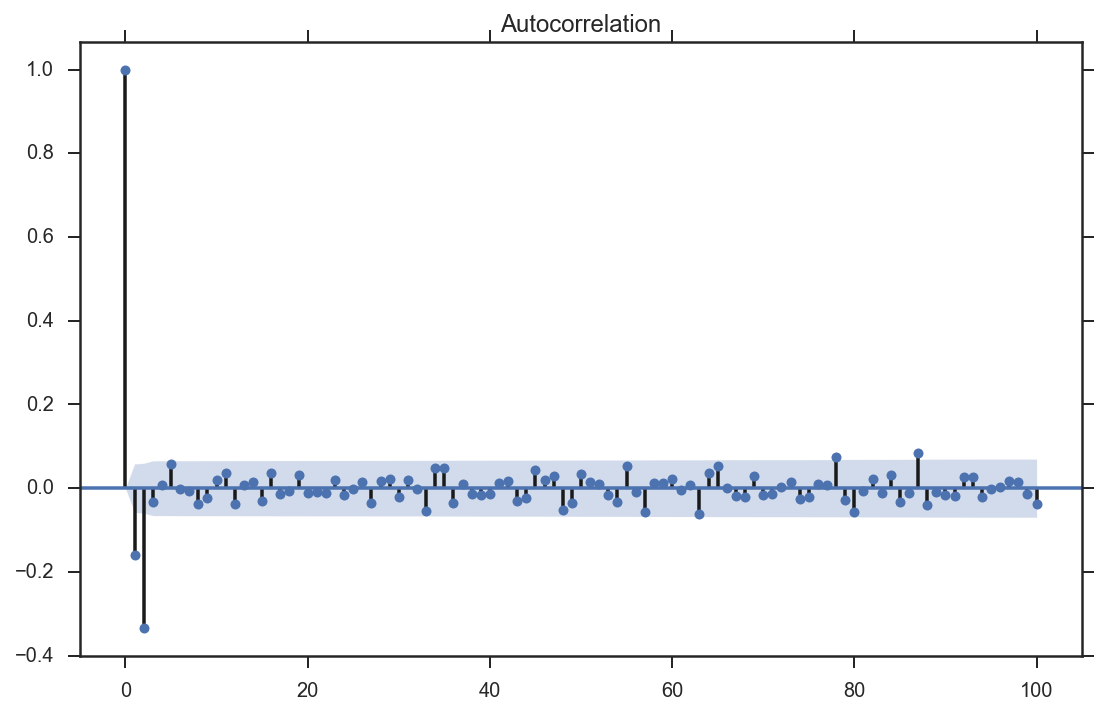

In [148]:
plot_acf(ar2.resid, lags=100)

These plots show values close to 0 onthe y-axis, so they are trustworthy. 

The autocorrelation plots look Ok also.

<h2> 4. Let's turn now to the solar data analysis. </h2>

In [149]:
ca_solar_df_num_corr  =  ca_solar_df_num.corr()
ca_solar_df_num_corr

Nameplate_Rating  CEC_PTC_Rating  \
Nameplate_Rating                             1.000000        0.999892   
CEC_PTC_Rating                               0.999892        1.000000   
CSI_Rating                                   0.987841        0.988074   
CEC_PTC_Rating_Single_Axis_Tracking          0.605686        0.608225   
CEC_PTC_Rating_Dual_Axis_Tracking           -0.000708       -0.000704   
CSI_Rating_Single_Axis_Tracking              0.604919        0.607109   
CSI_Rating_Dual_Axis_Tracking               -0.000703       -0.000698   
ZIP                                         -0.037877       -0.037988   
zone                                         0.032614        0.032532   
avg_temp                                     0.038961        0.039158   

                                     CSI_Rating  \
Nameplate_Rating                       0.987841   
CEC_PTC_Rating                         0.988074   
CSI_Rating                             1.000000   
CEC_PTC_Rating_Single_Axis_Tracking    0.713635   
CEC_PTC_Rating_Dual_Axis_Tracking     -0.000649   
CSI_Rating_Single_Axis_Tracking        0.714478   
CSI_Rating_Dual_Axis_Tracking         -0.000644   
ZIP                                   -0.041128   
zone                                   0.038013   
avg_temp                               0.042656   

                                     CEC_PTC_Rating_Single_Axis_Tracking  \
Nameplate_Rating                                                0.605686   
CEC_PTC_Rating                                                  0.608225   
CSI_Rating                                                      0.713635   
CEC_PTC_Rating_Single_Axis_Tracking                             1.000000   
CEC_PTC_Rating_Dual_Axis_Tracking                              -0.001039   
CSI_Rating_Single_Axis_Tracking                                 0.998567   
CSI_Rating_Dual_Axis_Tracking                                  -0.001038   
ZIP                                                            -0.028211   
zone                                                            0.032043   
avg_temp                                                        0.030229   

                                     CEC_PTC_Rating_Dual_Axis_Tracking  \
Nameplate_Rating                                             -0.000708   
CEC_PTC_Rating                                               -0.000704   
CSI_Rating                                                   -0.000649   
CEC_PTC_Rating_Single_Axis_Tracking                          -0.001039   
CEC_PTC_Rating_Dual_Axis_Tracking                             1.000000   
CSI_Rating_Single_Axis_Tracking                              -0.001025   
CSI_Rating_Dual_Axis_Tracking                                 0.999990   
ZIP                                                          -0.010080   
zone                                                          0.019898   
avg_temp                                                      0.003188   

                                     CSI_Rating_Single_Axis_Tracking  \
Nameplate_Rating                                            0.604919   
CEC_PTC_Rating                                              0.607109   
CSI_Rating                                                  0.714478   
CEC_PTC_Rating_Single_Axis_Tracking                         0.998567   
CEC_PTC_Rating_Dual_Axis_Tracking                          -0.001025   
CSI_Rating_Single_Axis_Tracking                             1.000000   
CSI_Rating_Dual_Axis_Tracking                              -0.001024   
ZIP                                                        -0.028683   
zone                                                        0.032955   
avg_temp                                                    0.031040   

                                     CSI_Rating_Dual_Axis_Tracking       ZIP  \
Nameplate_Rating                                         -0.000703 -0.037877   
CEC_PTC_Rating                                           -0.000698

In [150]:
ca_solar_df_num.head(3)

Nameplate_Rating  CEC_PTC_Rating  CSI_Rating  \
49250             4.165           3.639       3.435   
7016             10.920           9.346       8.602   
2532              4.995           4.311       3.857   

       CEC_PTC_Rating_Single_Axis_Tracking  CEC_PTC_Rating_Dual_Axis_Tracking  \
49250                                  0.0                                0.0   
7016                                   0.0                                0.0   
2532                                   0.0                                0.0   

       CSI_Rating_Single_Axis_Tracking  CSI_Rating_Dual_Axis_Tracking    ZIP  \
49250                              0.0                            0.0  95476   
7016                               0.0                            0.0  93619   
2532                               0.0                            0.0  93312   

       zone   avg_temp  
49250   2.0  55.166667  
7016   13.0  58.166667  
2532   13.0  58.166667

<h2> 4.1 Some linear regression on CA solar data now. </h2>

In [153]:
target1 = 'CEC_PTC_Rating'
target1 = 'CSI_Rating'
non_target_cols1 = ['Nameplate_Rating', 'CEC_PTC_Rating', 'CEC_PTC_Rating_Single_Axis_Tracking',
                   'CEC_PTC_Rating_Dual_Axis_Tracking', 'CSI_Rating_Single_Axis_Tracking', 
                    'CSI_Rating_Dual_Axis_Tracking', 'ZIP', 'zone', 'avg_temp']
formula_simple1 = target1 + ' ~ ' + ' + '.join(non_target_cols1) + ' -1'
print formula_simple1

CSI_Rating ~ Nameplate_Rating + CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking + CEC_PTC_Rating_Dual_Axis_Tracking + CSI_Rating_Single_Axis_Tracking + CSI_Rating_Dual_Axis_Tracking + ZIP + zone + avg_temp -1


In [154]:
ss1 = StandardScaler()
X1_n = ss.fit_transform(ca_solar_df_num)

In [155]:
Y1, X1 = patsy.dmatrices(formula_simple1, data=ca_solar_df_num)

In [156]:
X1_n.shape, Y1.shape

((4517, 10), (4517, 1))

In [157]:
linreg1 = LinearRegression()

linreg_scores1 = cross_val_score(linreg1, X1_n, Y1, cv=10)

print linreg_scores1
print np.mean(linreg_scores1)

[ 1.          0.99999963  1.          0.99999973  1.          1.          1.
  1.          1.          1.        ]
0.999999936143


As in the case for PGE data, this impossibly good score means that I need to change the analysis formula. I will use Ridge regression with cross-validation.

<h2> 4.2 Ridge regression with cross-validation. </h2>

In [158]:
simple_formula1 = 'C(Nameplate_Rating) ~  CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking + \
                    CSI_Rating_Dual_Axis_Tracking +CSI_Rating_Single_Axis_Tracking + ZIP + C(zone)  + C(avg_temp) -1'
print simple_formula1

C(Nameplate_Rating) ~  CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking +                     CSI_Rating_Dual_Axis_Tracking +CSI_Rating_Single_Axis_Tracking + ZIP + C(zone)  + C(avg_temp) -1


In [159]:
Y1, X1 = patsy.dmatrices(simple_formula1, data=ca_solar_df_num)

In [160]:
ss1 = StandardScaler()
X1_n = ss.fit_transform(ca_solar_df_num)

In [161]:
ridge_alphas1 = np.logspace(0, 5, 200)

optimal_ridge1 = RidgeCV(alphas=ridge_alphas1, cv=5)
optimal_ridge1.fit(X1_n, Y1)

print optimal_ridge1.alpha_

3917.10149081


In [162]:
ridge1 = Ridge(alpha=optimal_ridge1.alpha_)

ridge_scores1 = cross_val_score(ridge1, X1_n, Y1, cv=10)

print ridge_scores1
print np.mean(ridge_scores1)

[-0.00135336 -0.00180422 -0.00161926 -0.00173795 -0.00174881 -0.00133118
 -0.00175376 -0.00153565 -0.00161251 -0.00138781]
-0.0015884509947


Ridge regression did not work. Let me run Stochastic Gradient Descent.

<h2> 4.3 Stochastic Gradient Descent. </h2>

In [163]:
target1 = 'Nameplate_Rating'
non_target_cols1 = ['CSI_Rating', 'CEC_PTC_Rating', 'CEC_PTC_Rating_Single_Axis_Tracking',
                   'CEC_PTC_Rating_Dual_Axis_Tracking', 'CSI_Rating_Single_Axis_Tracking', 
                    'CSI_Rating_Dual_Axis_Tracking', 'ZIP', 'zone', 'avg_temp']

formula_simple1 = target1 + ' ~ ' + ' + '.join(non_target_cols1) + ' -1'
print formula_simple1

Nameplate_Rating ~ CSI_Rating + CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking + CEC_PTC_Rating_Dual_Axis_Tracking + CSI_Rating_Single_Axis_Tracking + CSI_Rating_Dual_Axis_Tracking + ZIP + zone + avg_temp -1


In [164]:
ss1 = StandardScaler()
X1_n = ss.fit_transform(ca_solar_df_num)

In [165]:
Y1, X1 = patsy.dmatrices(formula_simple1, data=ca_solar_df_num)

In [166]:
simple_feature_names1 = X1.design_info.column_names

In [167]:
sgd_params1 = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':np.linspace(0.01, 10000, 100)
}

sgd_reg1 = SGDRegressor()
sgd_reg_gs1 = GridSearchCV(sgd_reg1, sgd_params1, cv=5, verbose=2)

In [168]:
sgd_reg_gs1.fit(X1_n, Y1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l2, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] ........

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1010.11, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1010.11, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1010.11, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1010.11, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1010.11, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1010.11, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1010.11, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1414.15, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1515.16, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2020.21, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2222.23, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2626.27, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2626.27, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2626.27, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2626.27, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2626.27, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2626.27, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2626.27, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2727.28, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2929.3, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3131.32, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3333.34, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3535.36, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4242.43, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4444.45, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4949.5, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=4949.5, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4949.5, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5454.55, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5454.55, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5454.55, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5454.55, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5454.55, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5454.55, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5454.55, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5757.58, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6262.63, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6262.63, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6262.63, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6868.69, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6868.69, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6868.69, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6868.69, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6868.69, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7474.75, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7979.8, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8282.83, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8484.85, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8787.88, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8989.9, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9292.93, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9494.95, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9494.95, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9494.95, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': array([  1.00000e-02,   1.01020e+02, ...,   9.89899e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [169]:
print sgd_reg_gs1.best_params_
print sgd_reg_gs1.best_score_
sgd_reg1 = sgd_reg_gs1.best_estimator_
print sgd_reg1

{'penalty': 'l2', 'alpha': 2121.2200000000003, 'loss': 'squared_loss'}
0.088235301808
SGDRegressor(alpha=2121.2200000000003, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)


The score is not that great. 

<h2> 4.4 User ElasticNet now to get the fit to the parameters. </h2>

In [170]:
enet_alphas1 = np.arange(0, 3.0, 0.05)
enet_score1, enet_coefs1 = elasticnet_coefs(X1, Y1, enet_alphas1)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [172]:
print "enet score is: ", enet_score1

enet score is:  0.999784081744


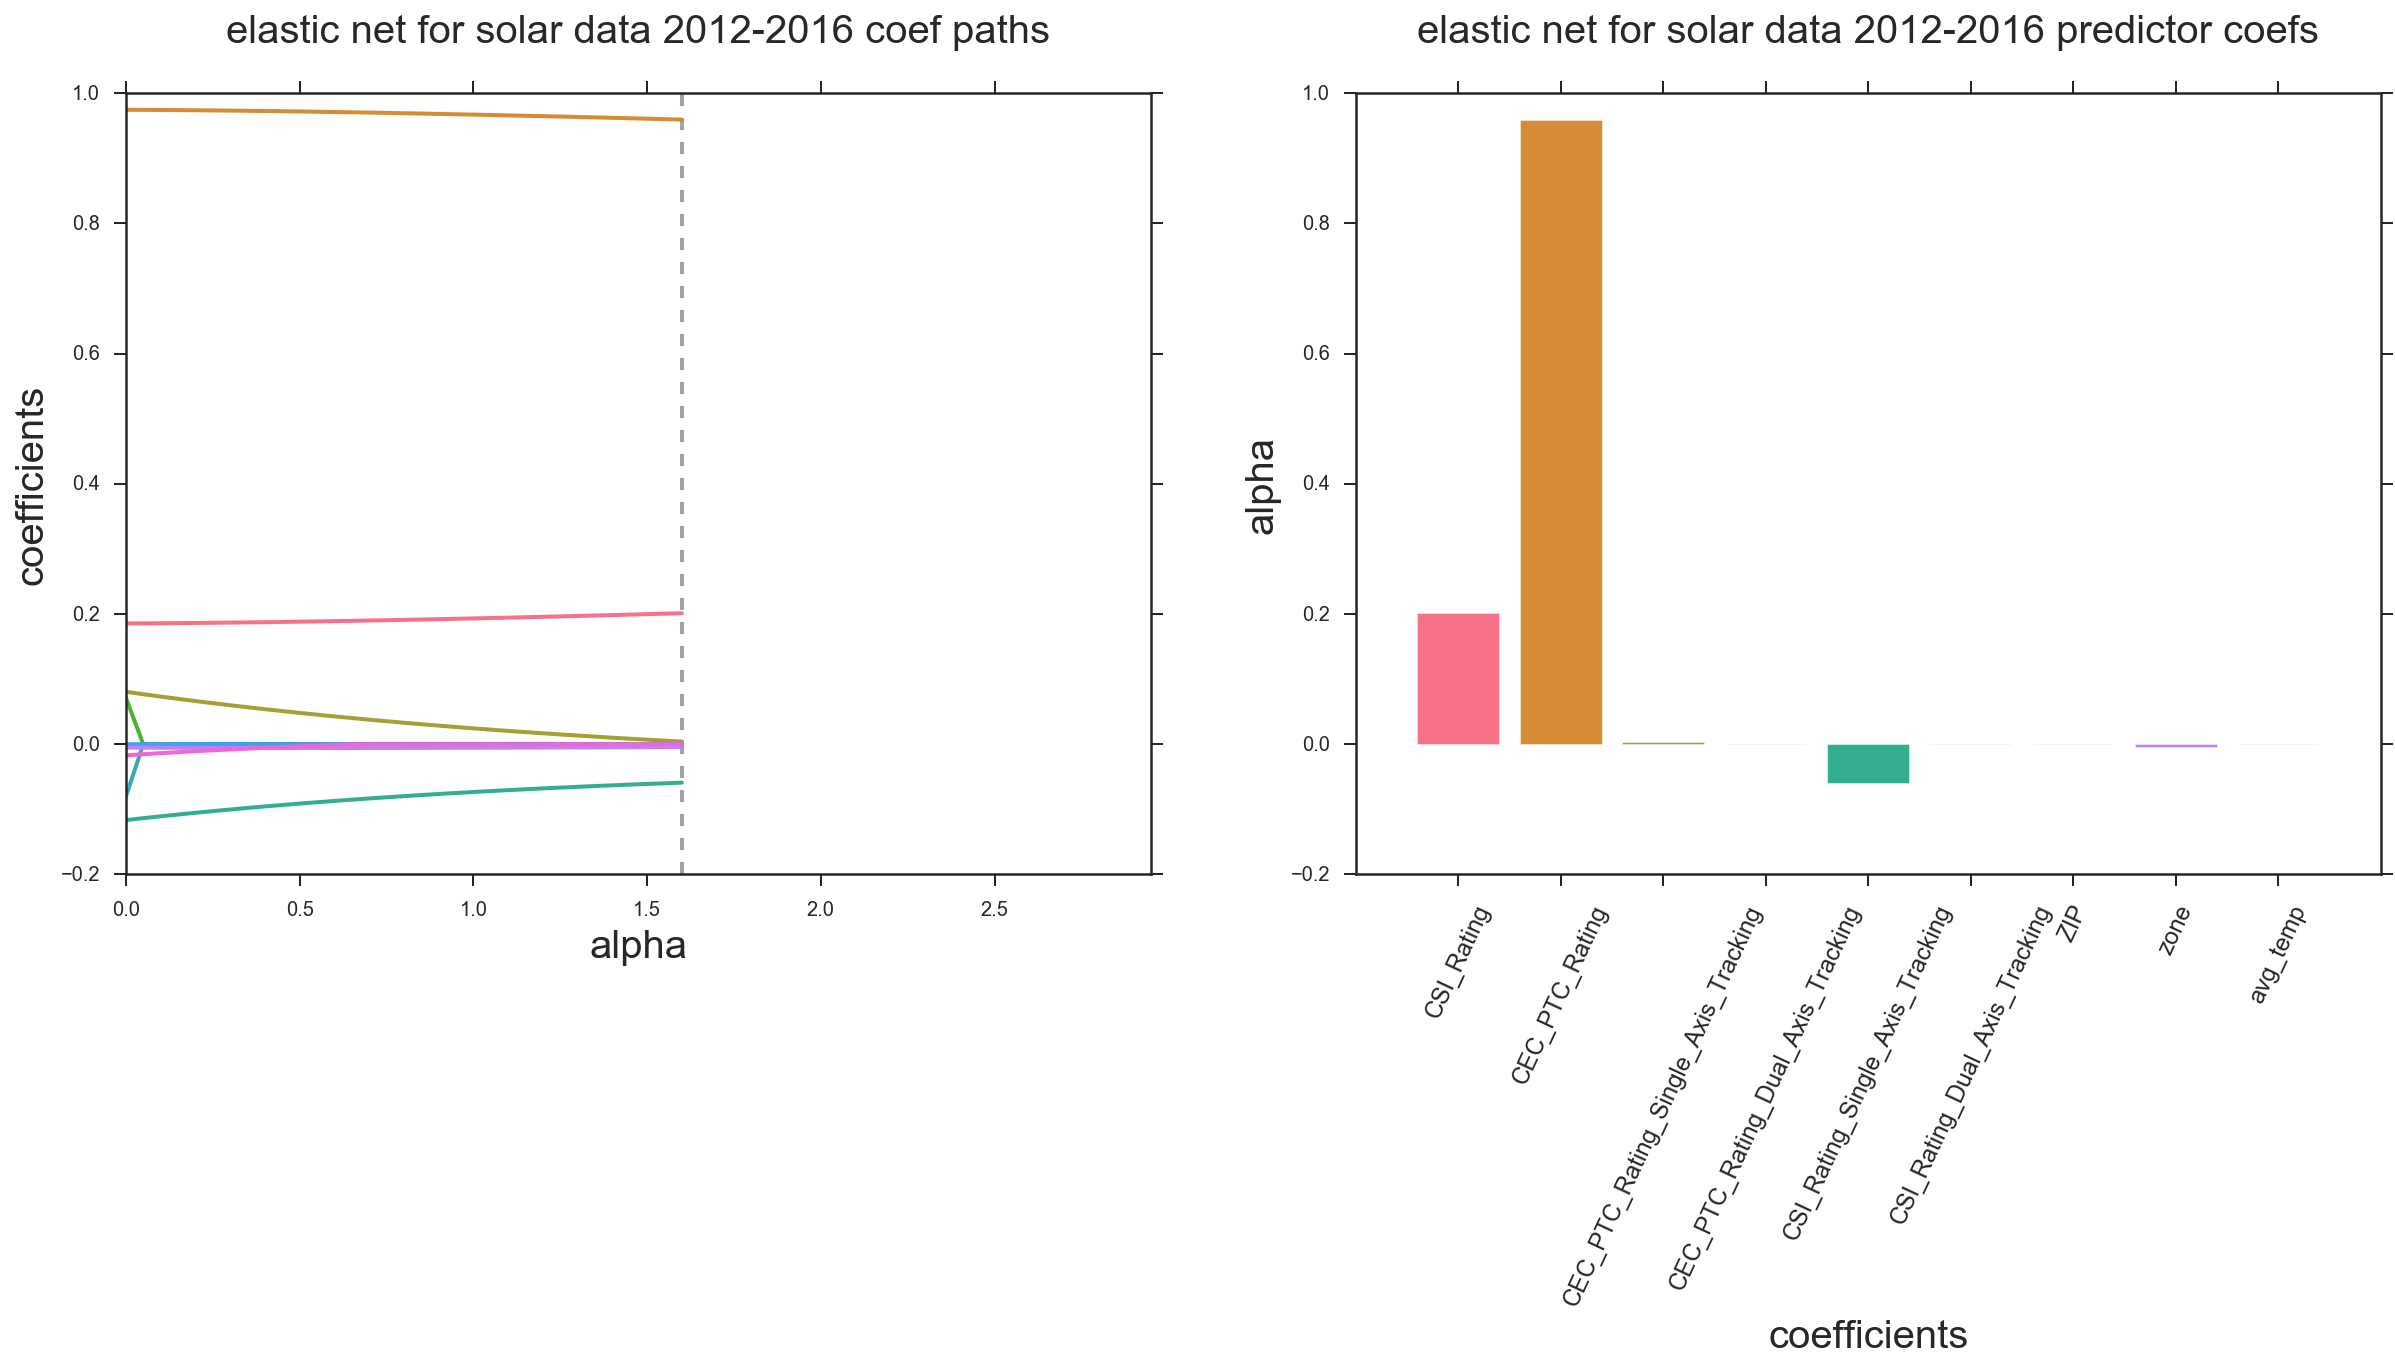

<function __main__.enet_plot_runner>

In [173]:
def enet_plot_runner(alpha=01.60):
    coef_plotter(enet_alphas1, enet_coefs1, simple_feature_names1, alpha, 
                 regtype='elastic net for solar data 2012-2016')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

![](4.3.2.1.png)

For CSI_Rating, we have correlation w Nameplate_Rating, CEC_PTC_Rating, CEC_PTC_Rating_Dual axis,, CSI Rating*, zone,
and anti-correlation w CEC_PTC rating single axis. 

<h2> 4.4 Let's also try time series analysis here, since the data also covers 2012-2016. </h2>

In [174]:
ca_nameplate_diff = ca_solar_df_num.Nameplate_Rating.diff()

In [175]:
ca_nameplate_diff.dropna(inplace=True)

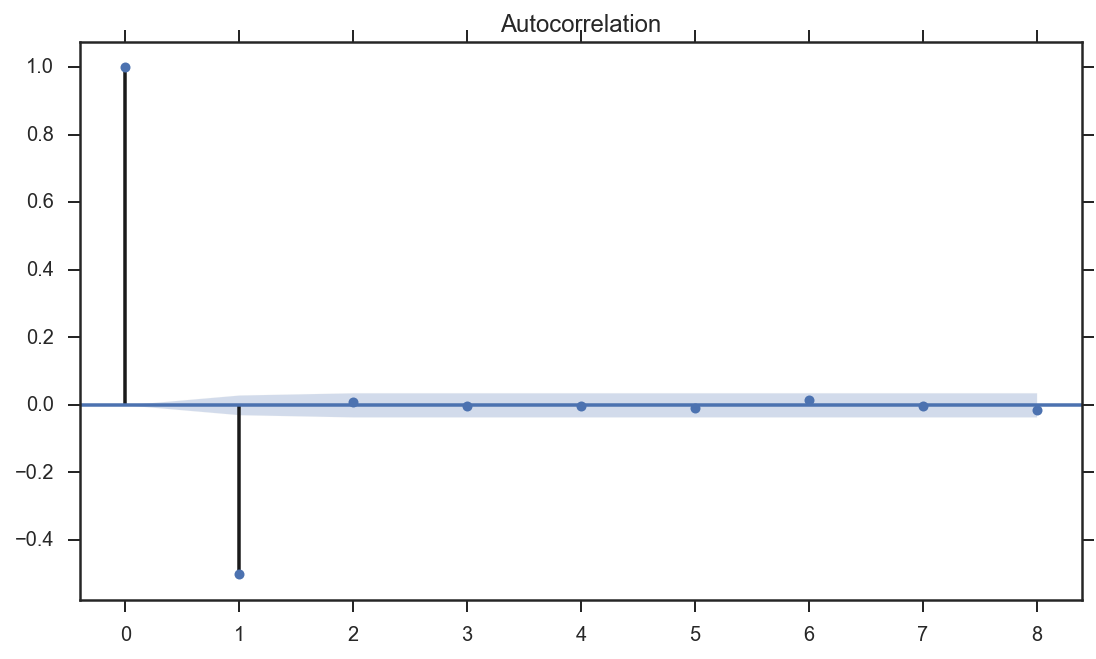

In [176]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(ca_nameplate_diff, lags=8, ax=ax)
plt.show()

In [177]:
ar3 = ARMA(ca_nameplate_diff.values, (1,0)).fit()
ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4516
Model:                     ARMA(1, 0)   Log Likelihood              -27174.598
Method:                       css-mle   S.D. of innovations             99.329
Date:                Fri, 14 Oct 2016   AIC                          54355.196
Time:                        10:56:39   BIC                          54374.443
Sample:                             0   HQIC                         54361.977
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0003      0.985     -0.000      1.000        -1.930     1.930
ar.L1.y       -0.5012      0.013    -38.929      0.000        -0.526    -0.476
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9954           +0.0000j            1.9954            0.5000
-----------------------------------------------------------------------------
"""

In [178]:
r2_score(ca_nameplate_diff, ar3.fittedvalues)

0.25127605932876007

On AWS I get: 0.22957776323642776

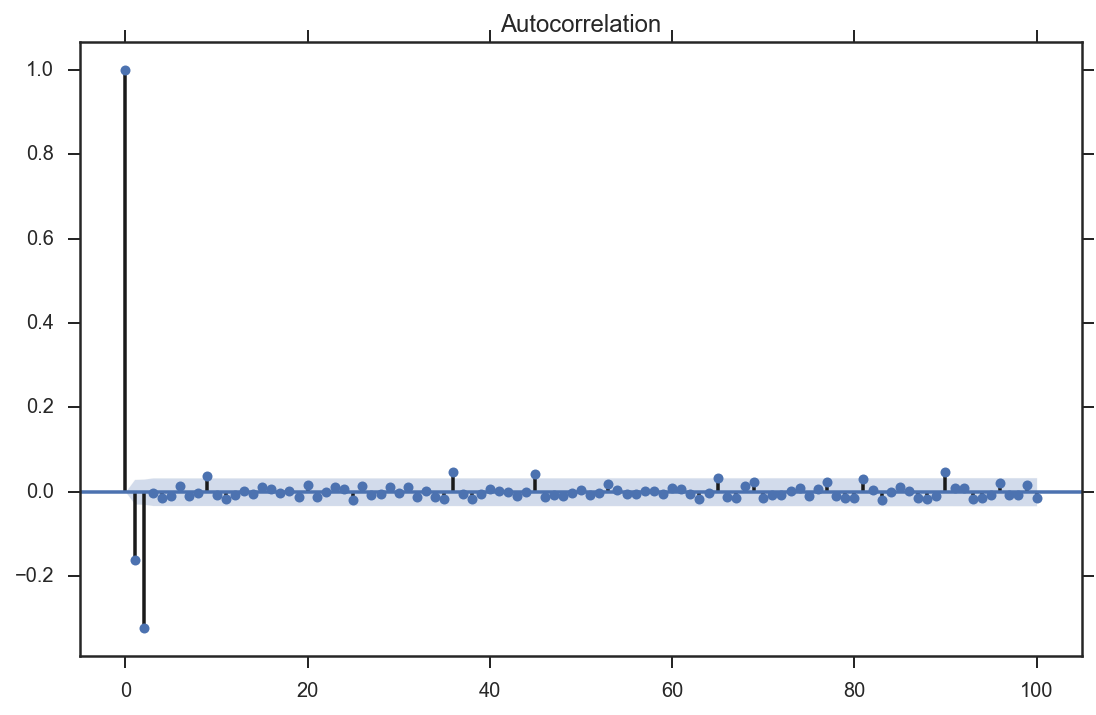

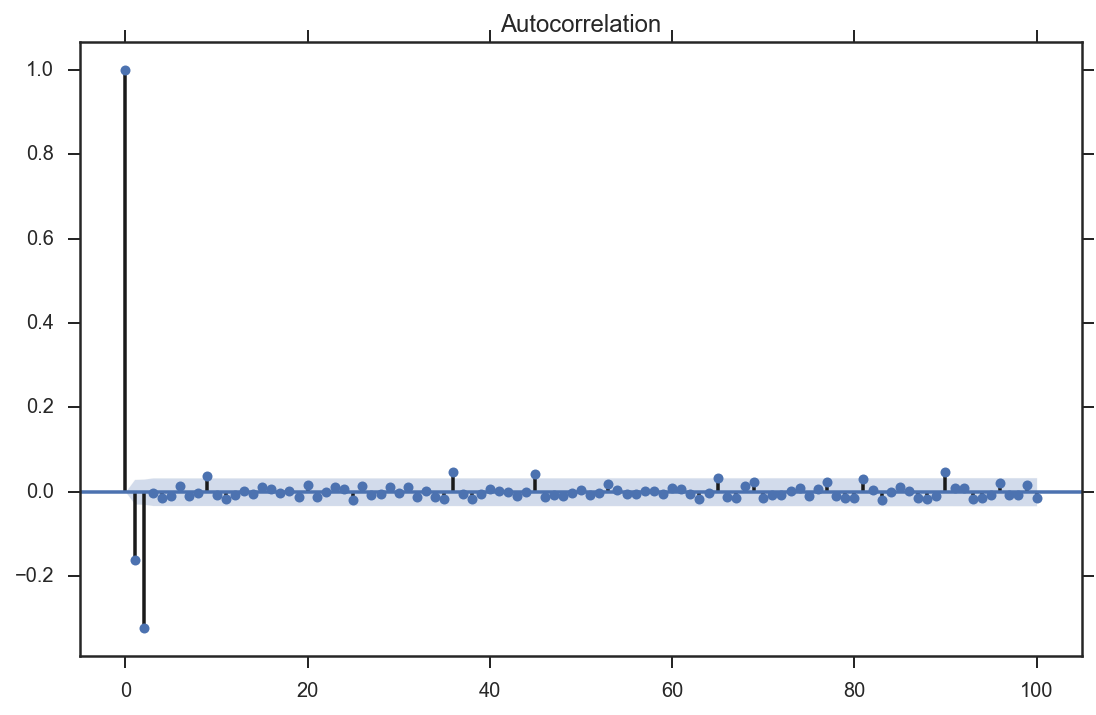

In [179]:
plot_acf(ar3.resid, lags=100)

Likewise, the auto-correlation plot seems OK, so we can trust the time series analysis. 

<h2> 5. Let's merge now the PGE data w the solar data, see what we can learn. </h2>

In [180]:
pge_q_num.head(3)

ZipCode  Month  Year  CustomerClass  Combined  TotalCustomers  \
933     94561      4  2013              2         1         12037.0   
2588    93249      5  2013              2         1           513.0   
2381    95972      4  2013              2         1            83.0   

       TotalkWh  AveragekWh  zone   avg_temp  
933   7017793.0       583.0  12.0  57.166667  
2588   297597.0       580.0  13.0  58.166667  
2381    62061.0       748.0  11.0  53.500000

In [181]:
ca_solar_df_num.head(3)

Nameplate_Rating  CEC_PTC_Rating  CSI_Rating  \
49250             4.165           3.639       3.435   
7016             10.920           9.346       8.602   
2532              4.995           4.311       3.857   

       CEC_PTC_Rating_Single_Axis_Tracking  CEC_PTC_Rating_Dual_Axis_Tracking  \
49250                                  0.0                                0.0   
7016                                   0.0                                0.0   
2532                                   0.0                                0.0   

       CSI_Rating_Single_Axis_Tracking  CSI_Rating_Dual_Axis_Tracking    ZIP  \
49250                              0.0                            0.0  95476   
7016                               0.0                            0.0  93619   
2532                               0.0                            0.0  93312   

       zone   avg_temp  
49250   2.0  55.166667  
7016   13.0  58.166667  
2532   13.0  58.166667

Adding now some columns from ca_solar_df_num to pge_q_num using dictionaries on ZIP/ZipCode. 
Since solar kWh numbers are generated, while pge kWh consumed, we multiply the solar numbers by -1 to show this relationship.

In [182]:
ca_solar_df_num.iloc[2,7]

93312.0

I build dictionaries to connect various solar data to zip code. I can add these vars to
the PGE data table.

In [184]:
zip_to_nameplate_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 0]
    zip_to_nameplate_dict[zip_val]  = kwh_val

In [185]:
pge_q_num['nameplate']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_nameplate_dict)

In [186]:
pge_q_num.dropna(inplace=True)

In [187]:
zip_to_cec_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 1]
    zip_to_cec_dict[zip_val]  = kwh_val

In [188]:
pge_q_num['cec']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_dict)

In [189]:
pge_q_num.dropna(inplace=True)

In [190]:
zip_to_csi_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 2]
    zip_to_csi_dict[zip_val]  = kwh_val

In [191]:
pge_q_num['csi']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_dict)

In [192]:
pge_q_num.dropna(inplace=True)

In [193]:
zip_to_cec_1_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 3]
    zip_to_cec_1_tracking_dict[zip_val]  = kwh_val

In [194]:
pge_q_num['cec_1_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_1_tracking_dict)

In [195]:
pge_q_num.dropna(inplace=True)

In [196]:
zip_to_cec_2_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 4]
    zip_to_cec_2_tracking_dict[zip_val]  = kwh_val

In [197]:
pge_q_num['cec_2_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_2_tracking_dict)

In [198]:
pge_q_num.dropna(inplace=True)

In [199]:
zip_to_csi_1_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 5]
    zip_to_csi_1_tracking_dict[zip_val]  = kwh_val

In [200]:
pge_q_num['csi_1_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_1_tracking_dict)

In [204]:
pge_q_num.dropna(inplace=True)

In [205]:
zip_to_csi_2_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 6]
    zip_to_csi_2_tracking_dict[zip_val]  = kwh_val

In [206]:
pge_q_num['csi_2_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_2_tracking_dict)

In [207]:
pge_q_num.dropna(inplace=True)

In [208]:
pge_q_num.head(3)

ZipCode  Month  Year  CustomerClass  Combined  TotalCustomers  \
933     94561      4  2013              2         1         12037.0   
4040    95336      5  2012              2         1         14368.0   
2929    93631      2  2015              1         1           410.0   

       TotalkWh  AveragekWh  zone   avg_temp  nameplate    cec    csi  \
933   7017793.0       583.0  12.0  57.166667      -4.44 -3.772 -3.434   
4040  9682526.0       674.0  12.0  57.166667      -4.41 -3.870 -3.763   
2929  1884711.0      4597.0  13.0  58.166667      -3.43 -3.015 -2.912   

      cec_1_track  cec_2_track  csi_1_track  csi_2_track  
933          -0.0         -0.0         -0.0         -0.0  
4040         -0.0         -0.0         -0.0         -0.0  
2929         -0.0         -0.0         -0.0         -0.0

In [209]:
pge_q_num_corr1 = pge_q_num.corr()

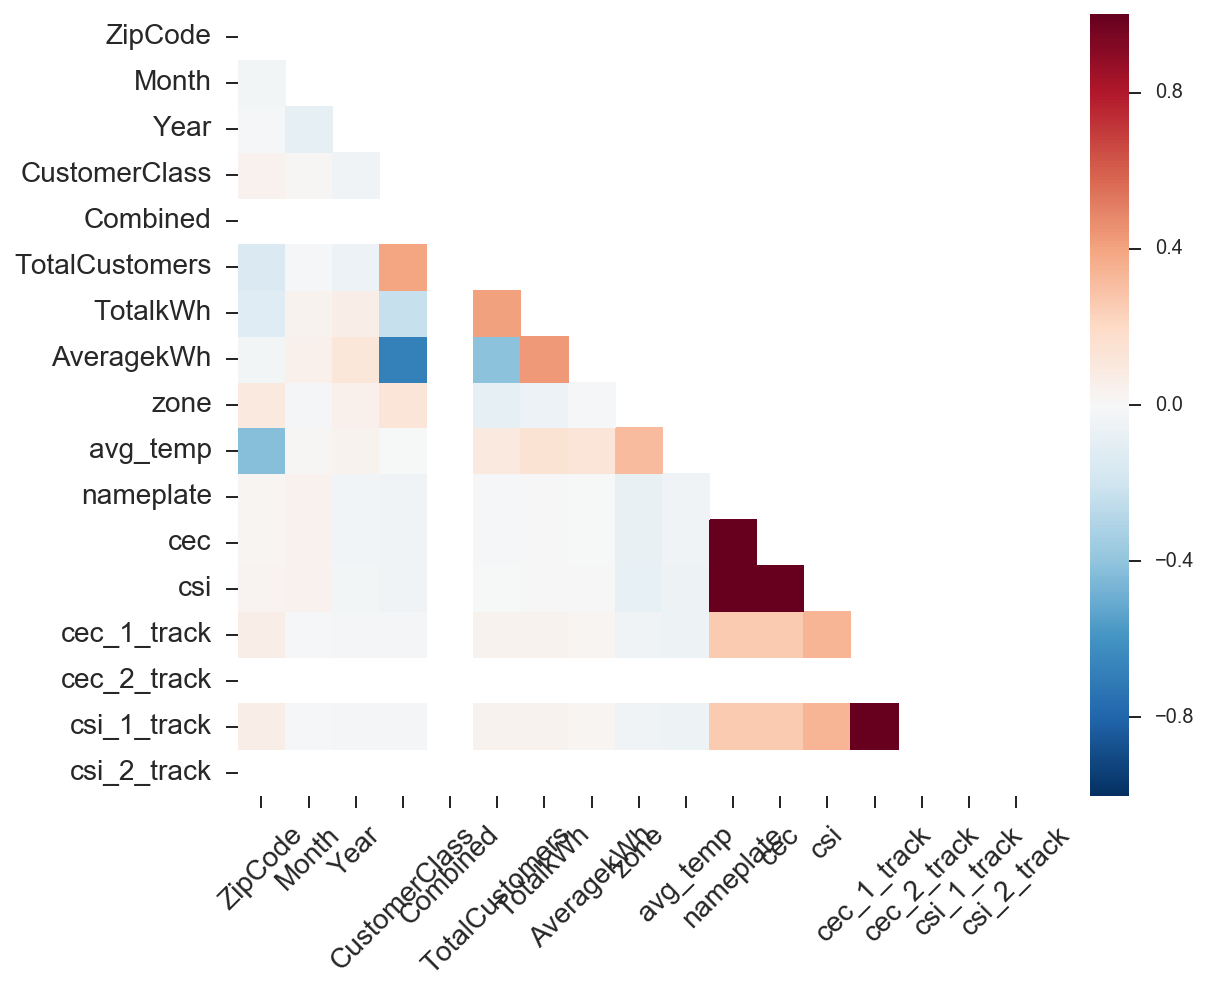

In [210]:
mask = np.zeros_like(pge_q_num_corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(pge_q_num_corr1, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

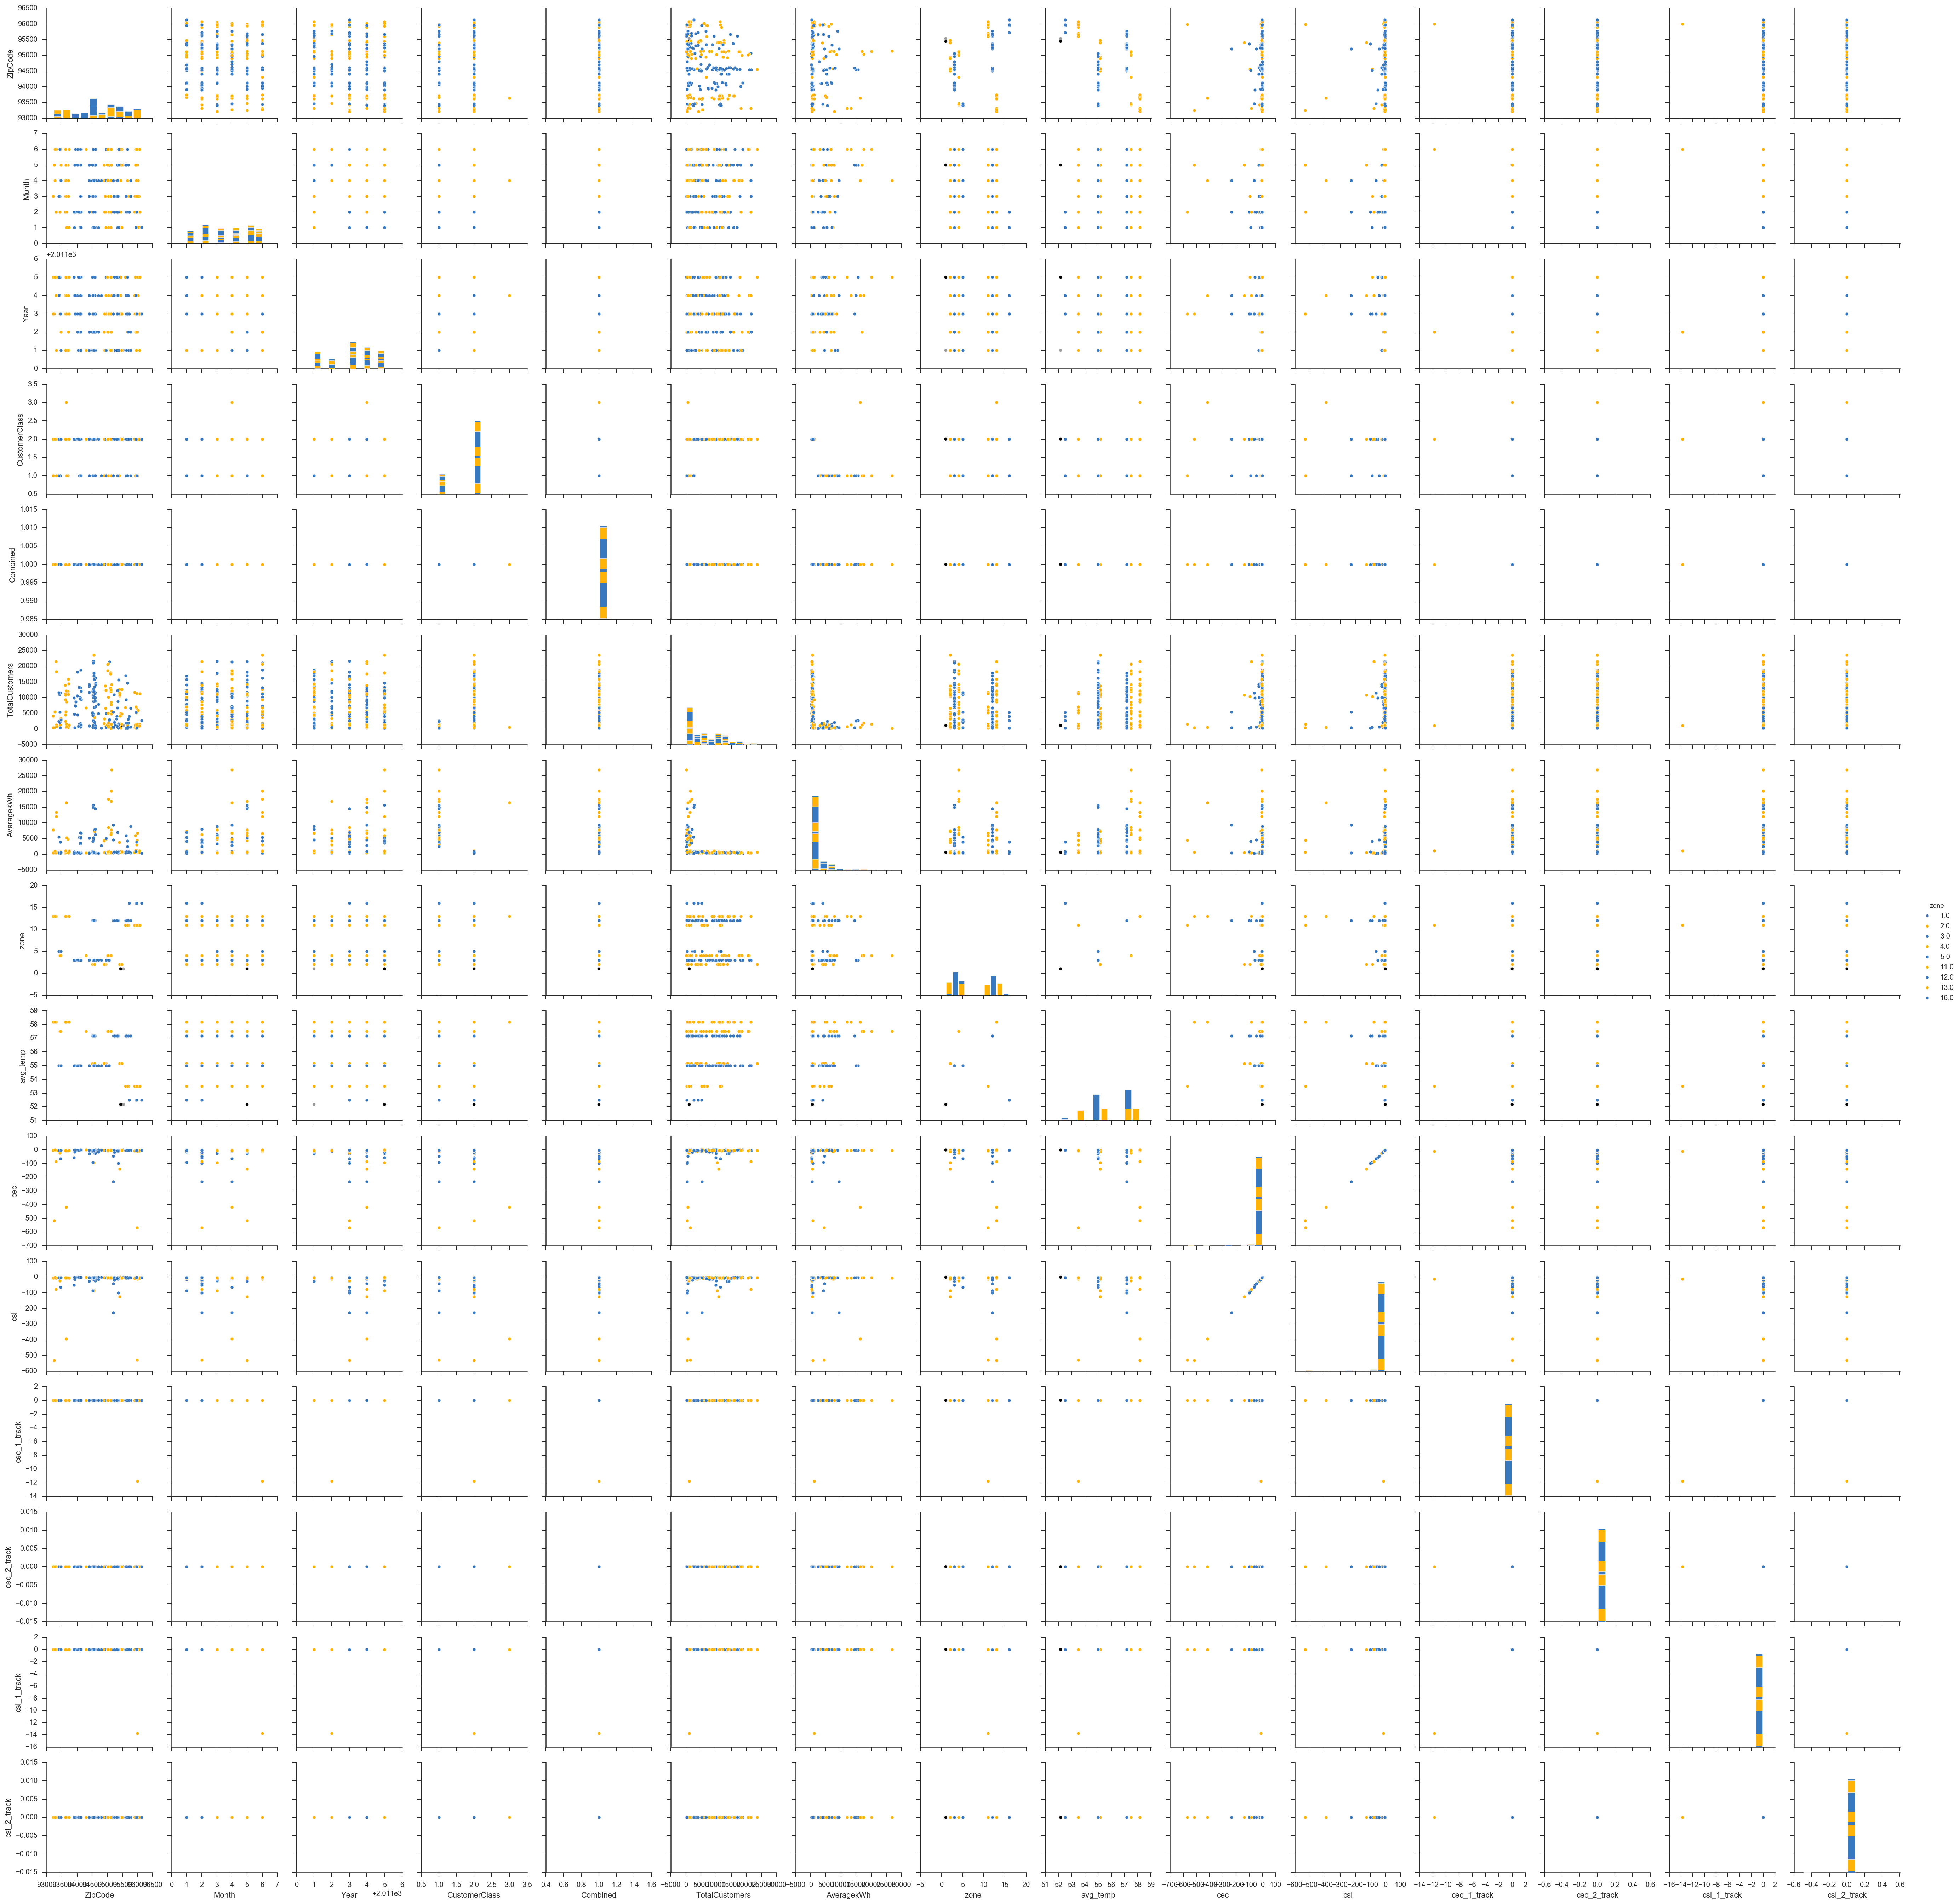

In [211]:
colvars = [x for x in pge_q_num if x not in ['TotalkWh','nameplate']]
electric_pairplotter(pge_q_num, colvars)

<h2> 5.1  Let's see if there is any correlation between TotalkWh (a PGE datum) 
and nameplate (a solar datum) by zone. </h2>

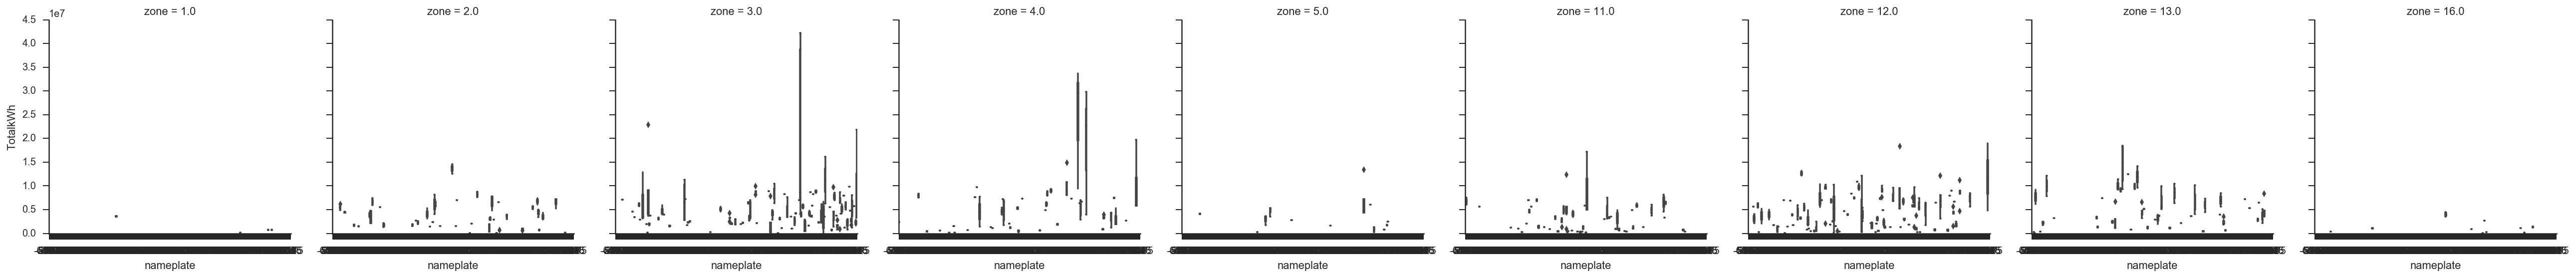

In [212]:
#sns.factorplot(x='Month', y='TotalkWh',col='Year', kind='box', data=pge_q_num)
sns.factorplot(x='nameplate', y='TotalkWh',col='zone', kind='box', data=pge_q_num)

![](5.1.2.1.png)

There is some correlation between Nameplate and TotalkWh in certain zones: 2,3,4, 11,12,13.

<h2> 5.2 Let's do now some Linear Regression. </h2>

In [213]:
formula_simple2 = 'C(TotalkWh) ~  C(nameplate) + C(TotalCustomers) + C(Month) + C(Year) + C(CustomerClass) + \
                   C(cec) + C(csi) + C(cec_2_track) + C(csi_1_track) + C(csi_2_track) -1 '  
# AveragekWh ~ C(TotalCustomers) + Month + Year + C(CustomerClass) + C(zone) + C(avg_temp) -1
#  C(zone) + C(avg_temp) -1 + \ 
print formula_simple2

C(TotalkWh) ~  C(nameplate) + C(TotalCustomers) + C(Month) + C(Year) + C(CustomerClass) +                    C(cec) + C(csi) + C(cec_2_track) + C(csi_1_track) + C(csi_2_track) -1 


In [214]:
Y2, X2 = patsy.dmatrices(formula_simple2, data=pge_q_num)

In [215]:
X2_n = ss.fit_transform(pge_q_num)

In [216]:
linreg2 = LinearRegression()

linreg_scores2 = cross_val_score(linreg2, X2_n, Y2, cv=10)

print linreg_scores2
print np.mean(linreg_scores2)

[-0.01190476 -0.01190476 -0.01190476 -0.01190476 -0.01190476 -0.01190476
 -0.01190476 -0.01190476 -0.01190476 -0.01204819]
-0.0119191049914


<h2> 5.3 I will do now ElasticNet.</h2>

In [217]:
target2 = 'TotalkWh'
non_target_cols2 = ['AveragekWh', 'CustomerClass', 'TotalCustomers', 'ZipCode', 'zone', 'nameplate', 'cec', 'csi' ,
                   'Month','cec_1_track', 'cec_2_track', 'csi_1_track', 'csi_2_track', 'avg_temp']
formula_simple2 = target2 + ' ~ ' + ' + '.join(non_target_cols2) + ' -1'
print formula_simple2

TotalkWh ~ AveragekWh + CustomerClass + TotalCustomers + ZipCode + zone + nameplate + cec + csi + Month + cec_1_track + cec_2_track + csi_1_track + csi_2_track + avg_temp -1


In [218]:
Y2, X2 = patsy.dmatrices(formula_simple2, data=pge_q_num)

In [219]:
simple_feature_names2 = X2.design_info.column_names

In [220]:
enet_alphas2 = np.arange(0, 3.0, 0.05)
enet_score2, enet_coefs2 = elasticnet_coefs(X2, Y2, enet_alphas2)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [221]:
print "enet score is: ", enet_score2

enet score is:  0.607653645757


Not great, but not that bad.

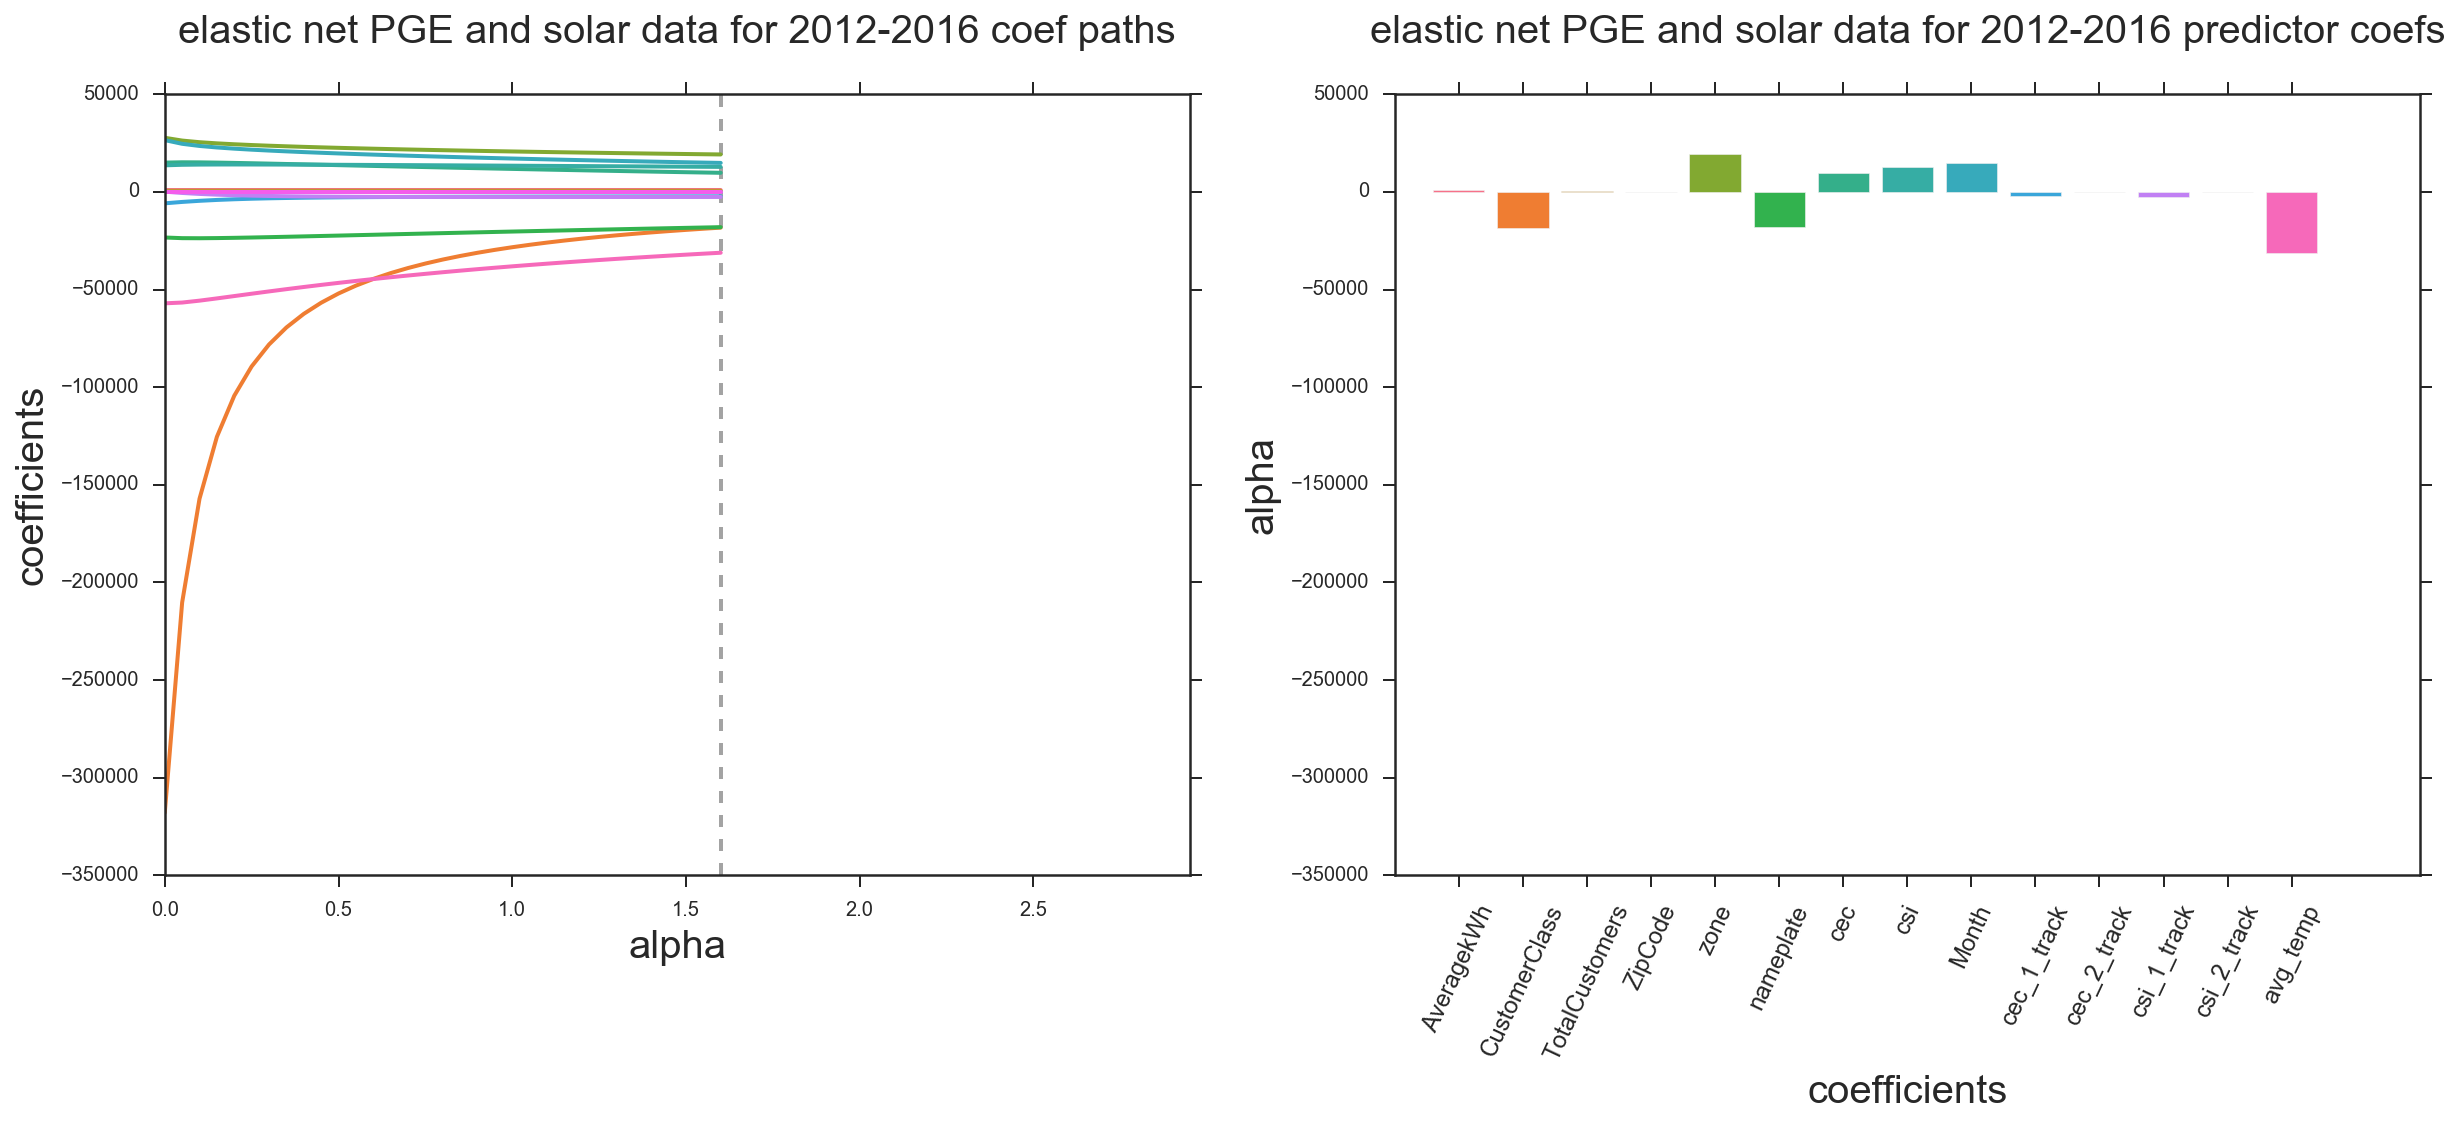

<function __main__.enet_plot_runner>

In [222]:
def enet_plot_runner(alpha=01.6):
    coef_plotter(enet_alphas2, enet_coefs2, simple_feature_names2, alpha, 
                 regtype='elastic net PGE and solar data for 2012-2016')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

![](5.4.1.2.png)

In [223]:
pge_q_num.head(3)

ZipCode  Month  Year  CustomerClass  Combined  TotalCustomers  \
933     94561      4  2013              2         1         12037.0   
4040    95336      5  2012              2         1         14368.0   
2929    93631      2  2015              1         1           410.0   

       TotalkWh  AveragekWh  zone   avg_temp  nameplate    cec    csi  \
933   7017793.0       583.0  12.0  57.166667      -4.44 -3.772 -3.434   
4040  9682526.0       674.0  12.0  57.166667      -4.41 -3.870 -3.763   
2929  1884711.0      4597.0  13.0  58.166667      -3.43 -3.015 -2.912   

      cec_1_track  cec_2_track  csi_1_track  csi_2_track  
933          -0.0         -0.0         -0.0         -0.0  
4040         -0.0         -0.0         -0.0         -0.0  
2929         -0.0         -0.0         -0.0         -0.0

<h2> 6. Analysis. </h2>

<h3> 6.1 PGE data analysis </h3>

Regarding the PGE data, it seems that 'TotalkWh' correlates with "zone" and "avg_temp" 
and anti-correlates with "Month", and "CustomerClass". The correlation seems surprising as average temperature 
is concerned, somewhat surprising regarding zones. I would not expect consumption to go up with temperature.
Maybe some of the electricity is used for cooling in hotter zones. Zones 10-16 are more in the desert region of CA. 


Regarding the anti-correlation between TotalkWh and Months, that seems reasonable: as decrease (go from Jun=6 to Jan=1) comsumption increases. There is more consumption in the winter, when is colder. 

There also seems to be some anti-correlation between different CustomerClasses and TotalkWh. The categories are:
Electric-Commercial'=1; 'Electric-Residential'=2; 'Electric-Agricultural'=3;'Electric-Industrial'=4.
Anti-correlation betweek TotalkWh and CustomerClass means that TotalkWh increases as CustomerClass is decreases, so
it is more for Electric-Commercial and Electric-Residential. So it seems these 2 Customer classes consume more electricity. 

On AWS, w the full data set,  TotalkWh correlates w CustomerClass[1], avg_temp, zone, and anti-correlates w CustomerClass[2] and CustomerClass[3].

<h3> 6.2 Solar data analysis </h3>

Regarding solar data, I need more detail data, by month for instance. For CSI_Rating, we have correlation w Nameplate_Rating, CEC_PTC_Rating* , CSI Rating*, zone, and anti-correlation w CEC_PTC rating single axis.
The correlation between Nameplate numbers and CEC* , CSI* numbers make sense, they are kWhs from different types
of panels in similar area. The interesting correlation is between Nameplate Rating and zones. The higher number zones,
like 10-16 are more in the desert part of CA. There, we would expect more sun, hence more electricity from solar panels. 

It is not clear why there is the anti-correlation w CEC_PTC_rating single axis. 

<h3> 6.3 Join PG&E and solar data analysis. </h3>

When our target is 'AveragekWh, and it correlates w 'CustomerClass, and correlates w 'zone', 'nameplate',
and 'avg_temp'. The correlation between AveragekWh and Nameplate, avg_temp(average temperature) makes sense: 
as Nameplate numbers, avg_temp increase, so do AveragekWh. 

The correlation beween AveragekWh and zones is interesting: as zones increase, the location is desert-like. There we expect more sunshine, hence more kWh used (perhaps cooling?!) 

The correlation between AveragekWh and CustomerClass is also intereting: as  in the PG&E data analysis, the higher CustomerClass numbers correspond to Electric-Agricultural and Electric-Industrial. These seem the bigger consumers of
electricity. 

If we switch to 'TotalkWh', we get correlation w 'CustomerClass[3]',  'csi', 'avg_temp', 
'zone' and 'cec'. 

On AWS, w the full data set,  TotalkWh correlates w CustomerClass[1], csi, avg_temp, zone, and anti-correlates w CustomerClass[2] and CustomerClass[3]. 

The correlation between TotalkWh and CSI*, avg_temp and CEC* is interesting: the more TotalkWh used, more solar power is generated by solar panels. So maybe people we switching to more solar power generation. 

The correlation between TotalkWh and avg_temp and zone is reasonable: higher temperature, higher use of electricity (maybe cooling, as above); and higher zones are in the desert, correlating with higher temperature. 

The last correlation, between TotalkWh and CustomerClass[3], Electric-Agricultural is interesting. Perhaps agricultural users need more electricity than other customers. 

<h2> Conclusion. </h2>

A data science project is a bit like making a documentary: we gather data, explore it, analyse it. At the end, 
we hope to find an interesting story to tell. Hopefully this was an interesting story. 